## THE CONTEXT

The TopBank is a bank which operates mainly in Germany, Spain and France offering financial products such as bank accounts, invetiment accounts and insurance. The bank markets banking services to its customers throught physical agencies and an online portal.


The mainly product is the bank account, which the customer can deposit the salary, make withdrawals, deposits and transfers to other accounts. The bank account has no costs for the customers and have 12 months of validity. Accordingly with the TopBank analytics team, each customer with a bank account returns a monetary value of 15% of their estimated salary if it is lower than the average estimated salaries and 20% if the estimated salary is greater than the average. This amount is calculated annually.



## THE CHALLENGE


In the last months, the analytics team realized the bank account cancellation rate risen considerably. Worried with the exit rate increment, they need prepare an action plan in order to decrease the customers exit rate (this customers exit rate is known as CHURN).


As Data Science consultant, the job is to create an action plan in order to decrease the churn rate and show to the CEO the financial return of the solution.


To assist in the action plan, a budget of $10000 was made available to be used as an incentive for the customer to stay at the bank.

## Solution Planning

- First look at the dataset.
- Cleaning Dataset.
- EDA.
- Modeling.
- Modeling evaluation.
- Solution delivery.

## Imports and Functions

In [1]:
import html
import plotly
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from boruta import BorutaPy
from sklearn.svm import SVC
from xgboost import XGBClassifier
from BorutaShap import BorutaShap
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from imblearn.combine import SMOTETomek 
from pandas_profiling import ProfileReport
from yellowbrick.classifier import ROCAUC
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_validate, cross_val_predict, RandomizedSearchCV, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve, cohen_kappa_score

### Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
 
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 10]
    plt.rcParams['font.size'] = 50
  
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
  
    sns.set()

def annot_plot(plot):
    for p in plot.patches:
        plot.annotate(format(float(p.get_height())), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize = 14)
    return None

jupyter_settings()

def eval_metrics(model_name, model, X_train, y_train):
    
    model = model.fit(X_train, y_train)
    
    metrics = {
        'Balanced_Accuracy': make_scorer(balanced_accuracy_score),
        'Precision': make_scorer(precision_score),
        'Recall': make_scorer(recall_score),
        'F1_Score': make_scorer(f1_score),
        'ROC_AUC_Score': make_scorer(roc_auc_score),
        'MMC': make_scorer(matthews_corrcoef),
        'Kappa_Score': make_scorer(cohen_kappa_score)
    }
    
    cv_model_scores = cross_validate(model, X_train, y_train, cv=10, scoring=metrics)
    
    metrics_results = pd.DataFrame.from_dict(cv_model_scores).drop(['fit_time', 'score_time'], axis=1)
    metrics_results = pd.DataFrame(metrics_results.mean()).T
    metrics_results['Model'] = model_name
    metrics_results.columns=['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC_Score', 'MMC', 'Kappa_Score', 'Model']
    metrics_results = metrics_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC_Score', 'MMC', 'Kappa_Score']]
    
    return metrics_results

def model_eval(model_name, model, X_train, X_test, y_train, y_test):

    model = model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    
    model_eval = pd.DataFrame({
        'Balanced_Accuracy': balanced_accuracy_score(y_test, y_hat),
        'Precision': precision_score(y_test, y_hat),
        'Recall': recall_score(y_test, y_hat),
        'F1_Score': f1_score(y_test, y_hat),
        'ROC_AUC': roc_auc_score(y_test, y_hat),
        'MCC': matthews_corrcoef(y_test, y_hat),
        'Kappa_Score': cohen_kappa_score(y_test, y_hat)}, index=[model_name])
    
    return model_eval

def cross_val(model_name, model, X, y, iterr):
    
    metrics = ['balanced_accuracy', 'f1', 'recall', 'roc_auc', 'precision']
    model_score = cross_validate(model, X, y, scoring=metrics, cv = iterr)
    
    df_scores = pd.DataFrame(model_score).drop(columns = ['fit_time', 'score_time']).mean()
    df_scores = pd.DataFrame(df_scores).T
    df_scores['Model'] = model_name
    df_scores.columns = ['Balanced_Accuracy', 'F1_Score', 'Recall',	'ROC_AUC',	'Precision', 'Model']
    df_scores = df_scores[['Model', 'Balanced_Accuracy', 'F1_Score', 'Recall',	'ROC_AUC',	'Precision']]
    
    return df_scores

Populating the interactive namespace from numpy and matplotlib


## Load Dataset

In [3]:
df = pd.read_csv('../data/churn.csv')

## First Look at the Dataset.

In [4]:
# Check first rows

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Check df shape

df.shape

(10000, 14)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [7]:
# Check dtypes

df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [8]:
# Check for NAN

df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

**Observations:**
- At the first look, the dataset seems to be already pretty cleaned.
- Gender must to be encoded.

## Data Cleaning

In [9]:
df2 = df.copy()

In [10]:
# exclude RowNumber column - this columns in just an row index and is not necessary.

df2.drop(columns = 'RowNumber', inplace=True)

In [11]:
df2.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<AxesSubplot:xlabel='CreditScore'>

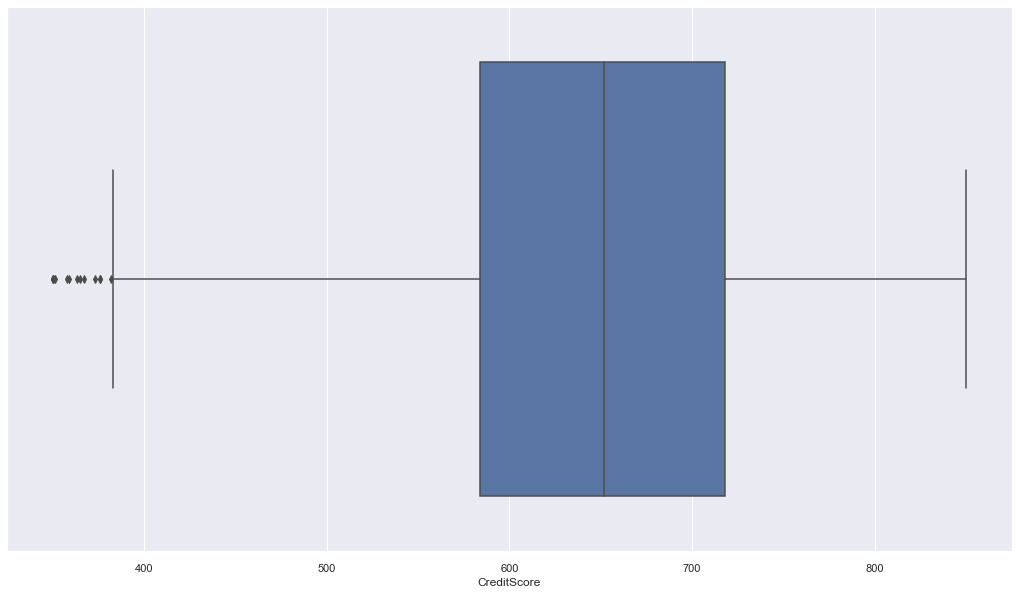

In [12]:
sns.boxplot(x = df2['CreditScore'])

<AxesSubplot:xlabel='Age'>

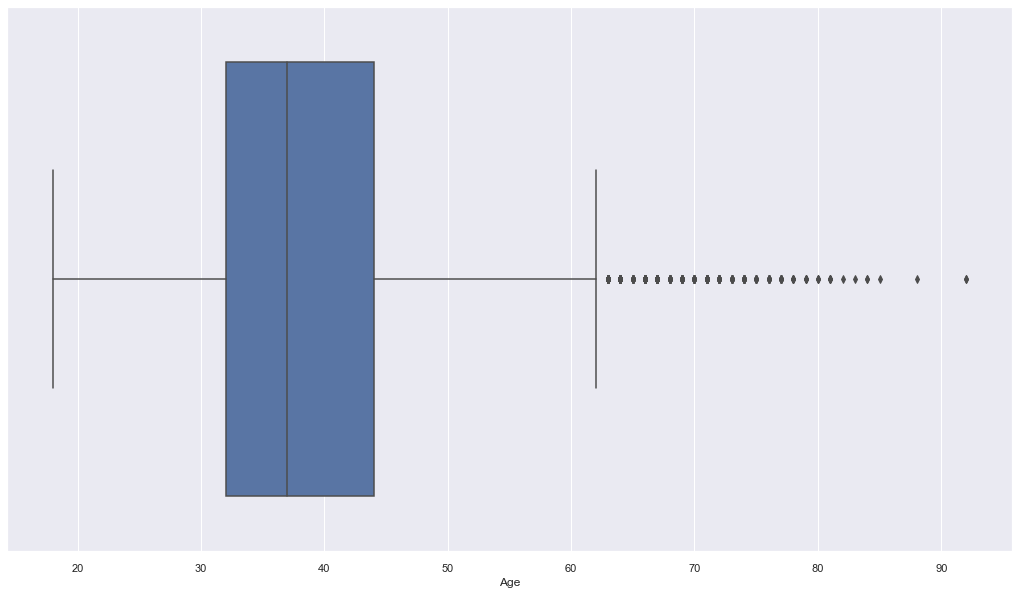

In [13]:
sns.boxplot(x = df2['Age'])

<AxesSubplot:xlabel='Balance'>

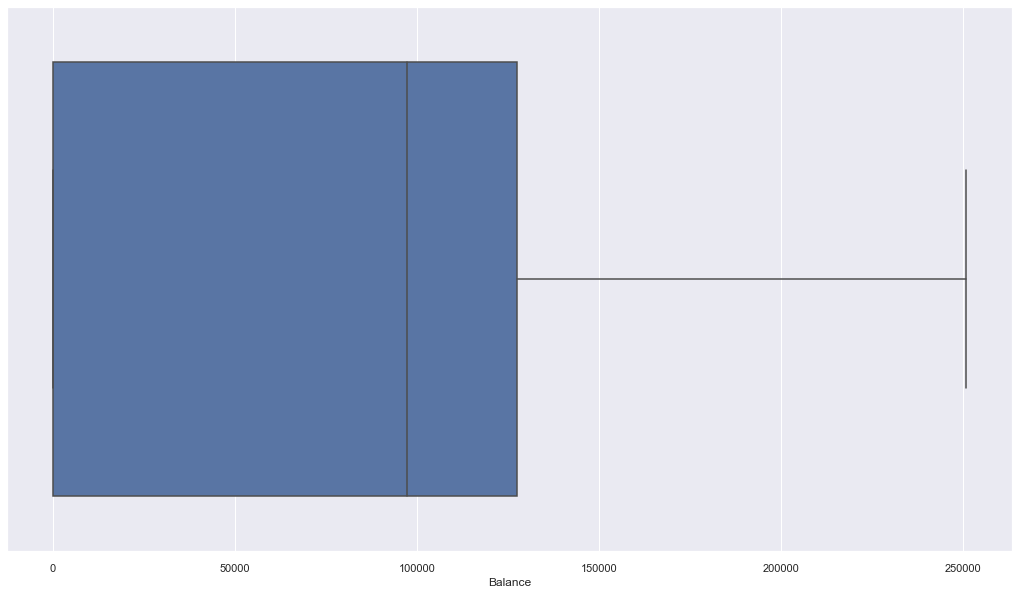

In [14]:
sns.boxplot(x = df2['Balance'])

<AxesSubplot:xlabel='EstimatedSalary'>

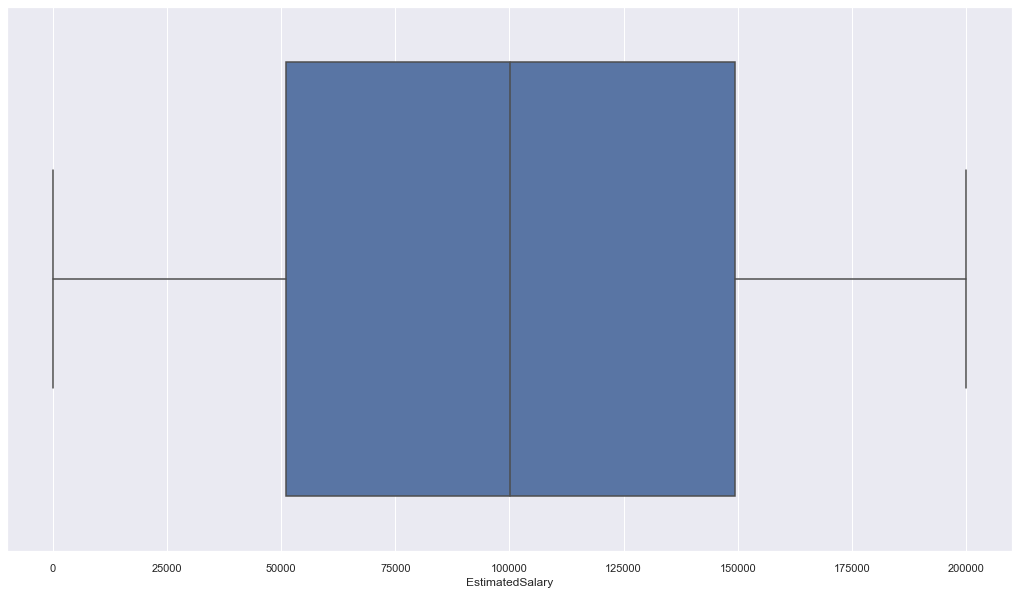

In [15]:
sns.boxplot(x = df2['EstimatedSalary'])

- The dataset is pretty cleaned, the gender encoding will be done after the EDA.

## Feature Engineering.

In [16]:
# Categorizing Balance values.

df2['BalanceCut'] = pd.cut(x=df2['Balance'], bins=[(df2['Balance'].min() - 1), 1000, 10000, 50000, 100000, 150000, 200000, (df2['Balance'].max() + 1)])

In [17]:
# Categorizing Estimated Salary accordingly to the average estimated salary

mean = df2['EstimatedSalary'].mean().round(2)
df2['MeanSalary'] = df2['EstimatedSalary'].apply(lambda x: 'Above' if x >= mean else 'Below')

In [18]:
# Categorizing Estimated Salary in 4 groups

df2['CatEstSalary'] = pd.cut(x=df2['EstimatedSalary'],
                             bins=[(df2['EstimatedSalary'].min() - 1),
                                   df2['EstimatedSalary'].describe()[4],
                                   df2['EstimatedSalary'].describe()[5],
                                   df2['EstimatedSalary'].describe()[6],
                                   df2['EstimatedSalary'].describe()[7] + 1])

In [19]:
# Balance per age
df2['BalancePerAge'] = round(df2['Balance'] / df2['Age'], 2)

In [20]:
df2.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceCut,MeanSalary,CatEstSalary,BalancePerAge
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,"(-1.0, 1000.0]",Above,"(100193.915, 149388.248]",0.00
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,"(50000.0, 100000.0]",Above,"(100193.915, 149388.248]",2044.09
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,"(150000.0, 200000.0]",Above,"(100193.915, 149388.248]",3801.45
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,"(-1.0, 1000.0]",Below,"(51002.11, 100193.915]",0.00
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,"(100000.0, 150000.0]",Below,"(51002.11, 100193.915]",2918.86


## EDA

**EDA Planning:**

1. Univariate analysis.
2. Hypothesis formulation.
3. Bivariated analysis - hypothesis validation.
4. Multivariate analysis.

### Univariated Analysis - Pandas Profiling Report.

In [21]:
df3 = df2.copy()

In [22]:
df3.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceCut,MeanSalary,CatEstSalary,BalancePerAge
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,"(-1.0, 1000.0]",Above,"(100193.915, 149388.248]",0.00
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,"(50000.0, 100000.0]",Above,"(100193.915, 149388.248]",2044.09
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,"(150000.0, 200000.0]",Above,"(100193.915, 149388.248]",3801.45
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,"(-1.0, 1000.0]",Below,"(51002.11, 100193.915]",0.00
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,"(100000.0, 150000.0]",Below,"(51002.11, 100193.915]",2918.86


In [23]:
# Pandas Proffiling

report1 = ProfileReport(df3, 'Churn Prediction Dataset 1st Report')
report1.to_file(output_file = '../reports/pp_report1.html')

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
report1

### Hypothesis Formulation

H1. Male customers are mole likely to churn than female customers.

H2. Younger customers are mole likely to churn than older customers.

H3. Customers with less time as customers are mole likely to churn.

H4. Customers with less balance values are more likely to churn.

H5. Customer with less bank products are more likely to churn.

H6. Customer without creditcard are more likely to churn.

H7. Active members are less likely to churn.

H8. Customer with bigger estimated salary are less likely to churn.

H9. Customers from which country are more likely to exit?

### Bivariated analysis - hypothesis validation. 

#### H1. Male customers are mole likely to churn than female customers.

In [25]:
df_gender = df3.groupby(['Gender'])['Exited'].value_counts(normalize=True).round(3)
df_gender = df_gender.mul(100).rename('Percent').reset_index()

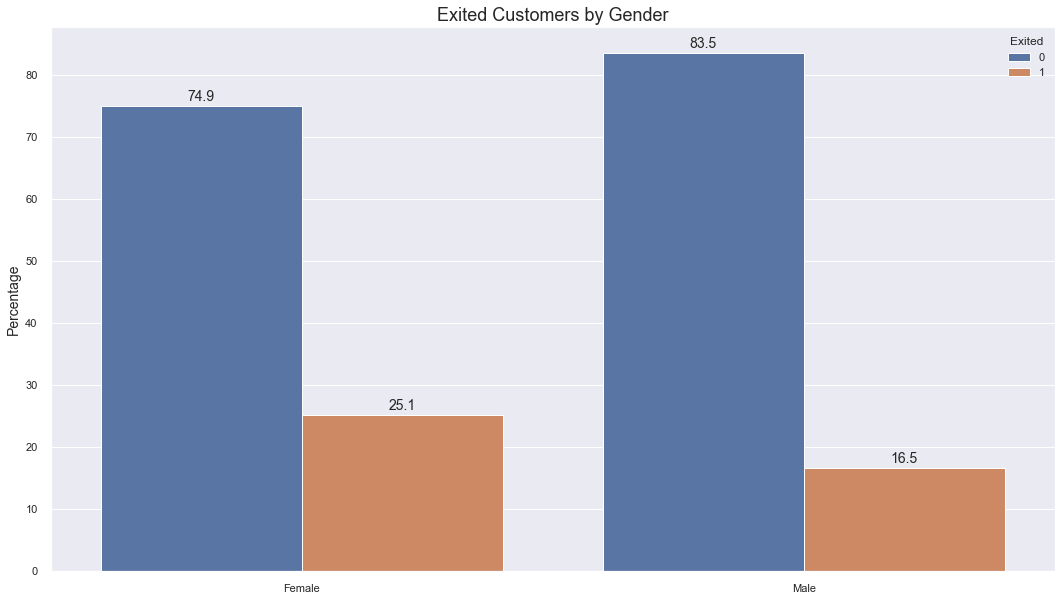

In [26]:
ax = sns.barplot('Gender', 'Percent', hue = 'Exited', data=df_gender)
ax.set_title('Exited Customers by Gender', fontsize = 18)
ax.set_xlabel('')
ax.set_ylabel('Percentage', fontsize=14)
annot_plot(ax)

**H1 Validation: FALSE**

    - Accordingly the data, women are more likely to churn than men.
        - More than 25% of women have exited the bank, while only 16,45% of man have exited.

#### H2. Younger customers are mole likely to churn than older customers.

In [27]:
df_age = df3.copy()
df_age['AgeGroup'] = df_age['Age'].apply(lambda x: 'Young' if x < 30 else 'Elder')

In [28]:
df_age = df_age.groupby('AgeGroup')['Exited'].value_counts(normalize=True).round(2)
df_age = df_age.mul(100).rename('Percent').reset_index()

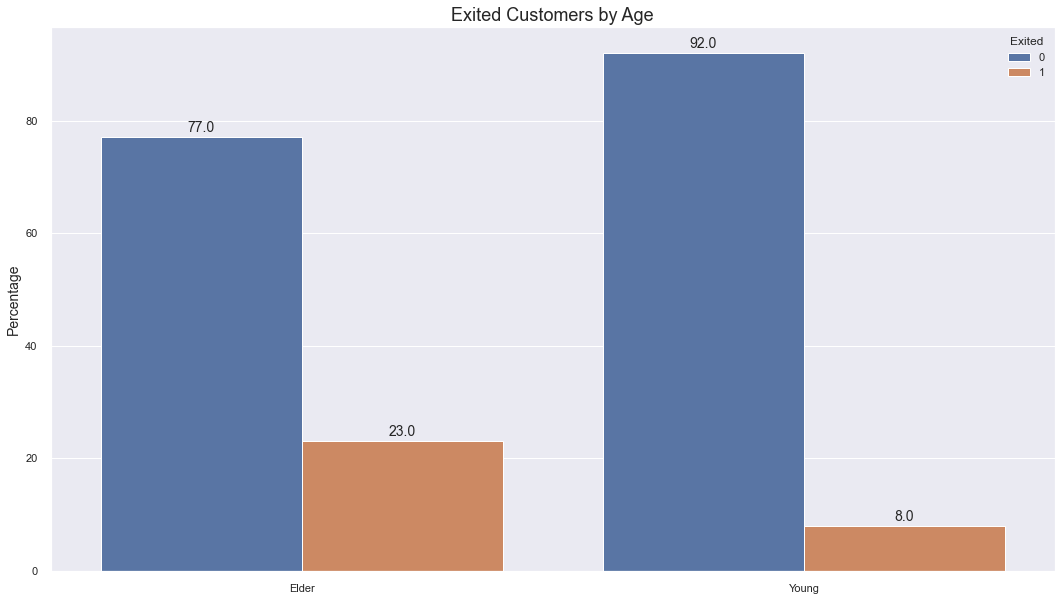

In [29]:
ax = sns.barplot('AgeGroup', 'Percent', hue = 'Exited', data=df_age)
ax.set_title('Exited Customers by Age', fontsize = 18)
ax.set_xlabel('')
ax.set_ylabel('Percentage', fontsize=14)
annot_plot(ax)

**H2 Validation: FALSE**

    - Accordingly the data, elder customers are more likely to churn than younger.
        - 23% of elder customers have exited the bank, while only 8% of younger customers have exited.

#### H3. Customers with less time as customers are mole likely to churn.

In [30]:
df_tenure = round(df3.groupby('Tenure')['Exited'].value_counts(normalize=True),2)
df_tenure = df_tenure.mul(100).rename('Percent').reset_index()

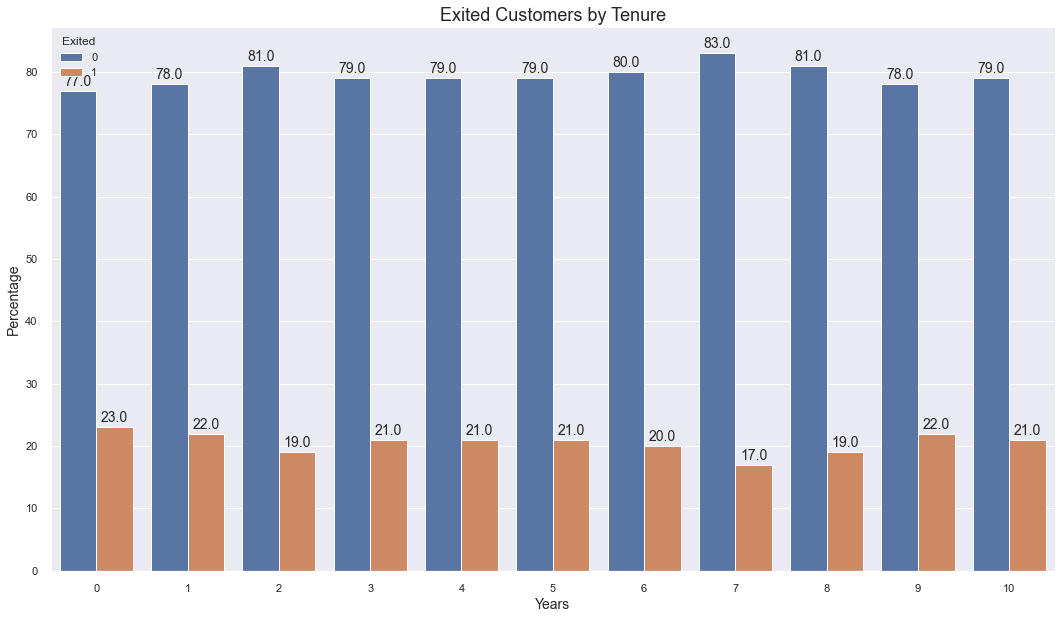

In [31]:
ax = sns.barplot('Tenure', 'Percent', hue = 'Exited', data=df_tenure)
ax.set_title('Exited Customers by Tenure', fontsize = 18)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
annot_plot(ax);

**H3 Validation: INCONCLUSIVE**

    - Accordingly the data, customers with less time as customers have almost the same exited proportion as customer with more time.
        - Customer with less than 4 years as customer have a range from 19% to 23% outings, while customer with more than 3 years have a range from 17% to 22%, almost the same.

#### H4. Customers with less balance values are more likely to churn.

<AxesSubplot:>

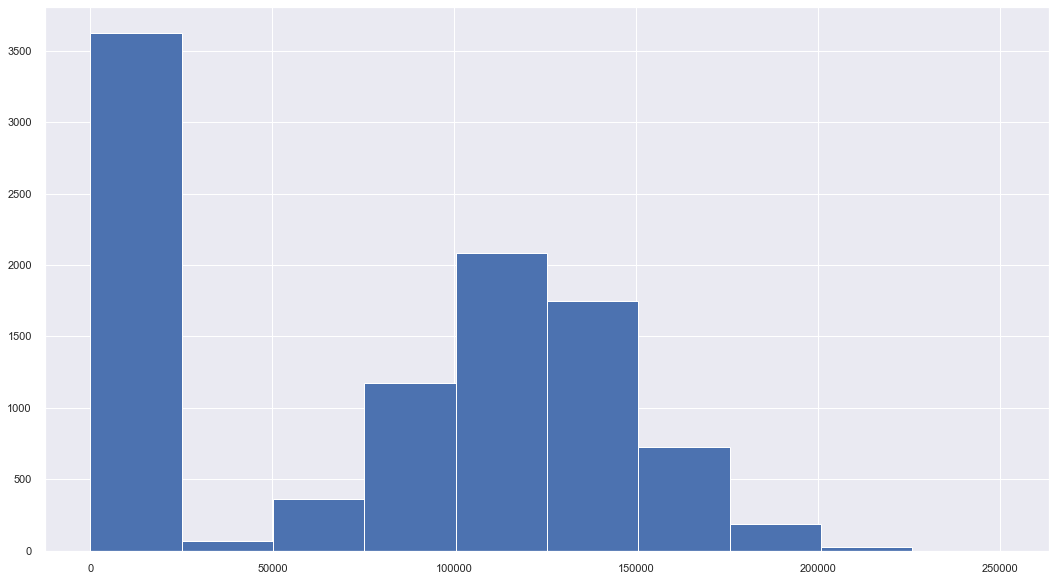

In [32]:
df3['Balance'].hist()

In [33]:
df_balance = round(df3.groupby('Exited')['Balance'].value_counts(normalize=True),2)
df_balance = df_balance.mul(100).rename('Percent').reset_index()

In [34]:
df3['BalanceCut'].value_counts()

(100000.0, 150000.0]     3830
(-1.0, 1000.0]           3617
(50000.0, 100000.0]      1509
(150000.0, 200000.0]      935
(10000.0, 50000.0]         74
(200000.0, 250899.09]      34
(1000.0, 10000.0]           1
Name: BalanceCut, dtype: int64

In [35]:
df_balance = df3.groupby('BalanceCut')['Exited'].value_counts(normalize=True).round(2)
df_balance2 = df3.groupby('BalanceCut')['Exited'].value_counts()
df_balance = df_balance.mul(100).rename('Percent').reset_index()
df_balance3 = pd.DataFrame(df_balance2).rename(columns = {'Exited':'Count'}).reset_index()

''

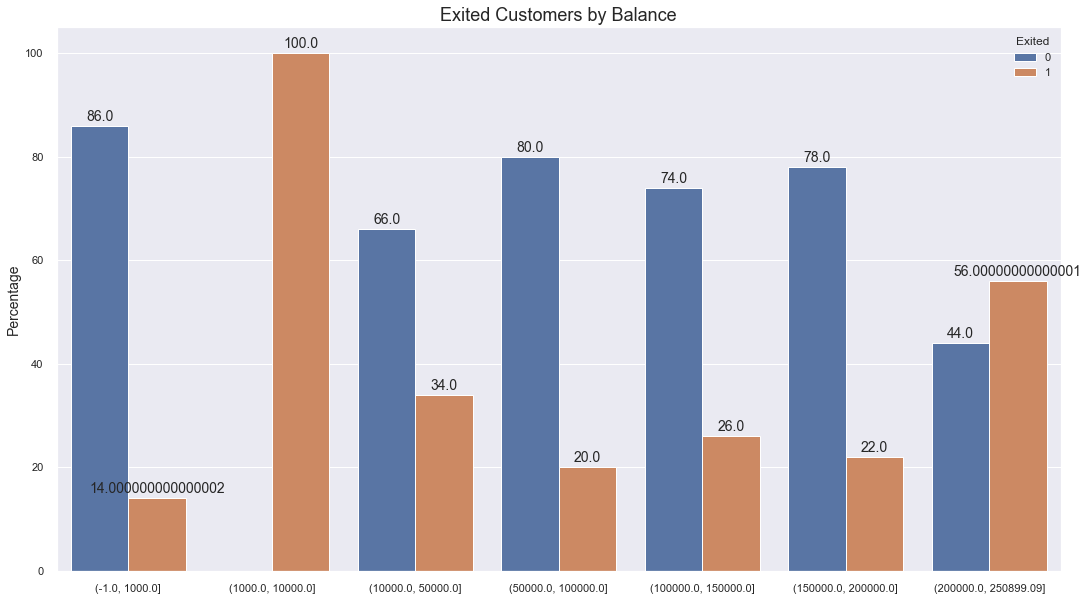

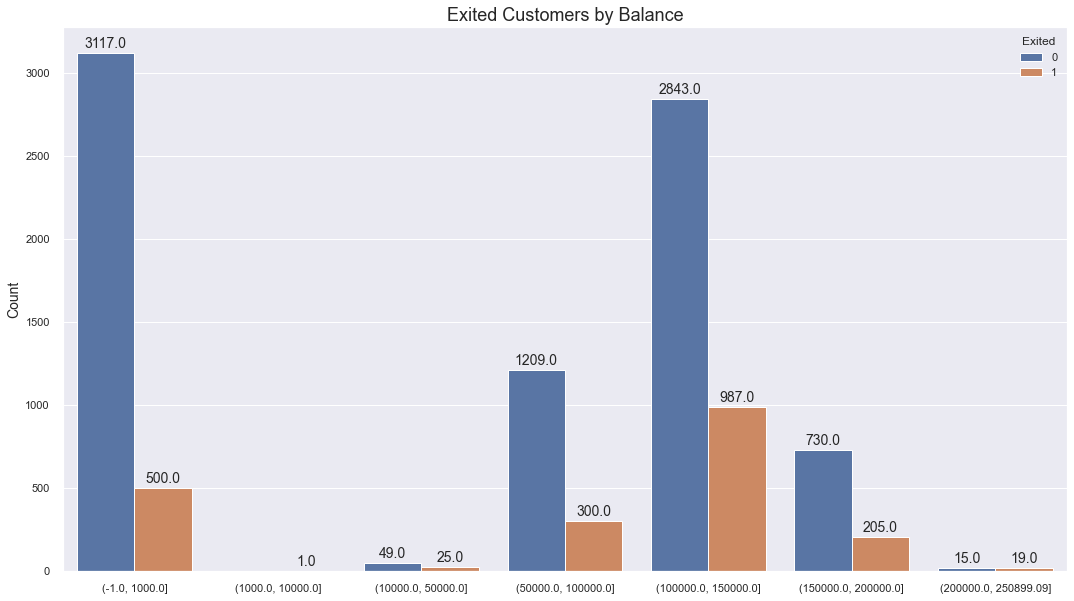

In [36]:
plt.subplots(1)

ax = sns.barplot('BalanceCut', 'Percent', hue = 'Exited', data=df_balance)
ax.set_title('Exited Customers by Balance', fontsize = 18)
ax.set_xlabel('')
ax.set_ylabel('Percentage', fontsize=14)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot('BalanceCut', 'Count',  hue = 'Exited', data=df_balance3)
ax2.set_title('Exited Customers by Balance', fontsize = 18)
ax2.set_xlabel('')
ax2.set_ylabel('Count', fontsize=14)
annot_plot(ax2)
;

In [37]:
display(df3[df3['Balance'] >= 10000]['Exited'].count())
display(df3[df3['Balance'] >= 10000]['Exited'].value_counts(normalize=True) * 100)

6382

0    75.93231
1    24.06769
Name: Exited, dtype: float64

In [38]:
display(df3[df3['Balance'] < 10000]['Exited'].count())
display(df3[df3['Balance'] < 10000]['Exited'].value_counts(normalize=True) * 100)

3618

0    86.15257
1    13.84743
Name: Exited, dtype: float64

**H4 Validation: FALSE**

    - Accordingly the data, customers with lower balance are more likely to remain customers.
        - Customer with balance lower than €10000 are more likely to remain customers. Only 13,8% of lower balance customers are 'Exited', while more than 24% of the customers with more than €10000 have exited.

#### H5. Customer with less bank products are more likely to churn.

In [39]:
df_prod = df3.groupby(['NumOfProducts'])['Exited'].value_counts(normalize=True).round(2)
df_prod = df_prod.mul(100).rename('Percent').reset_index()
df_prod2 = df3.groupby('NumOfProducts')['Exited'].value_counts()
df_prod3 = pd.DataFrame(df_prod2).rename(columns = {'Exited':'Count'}).reset_index()

''

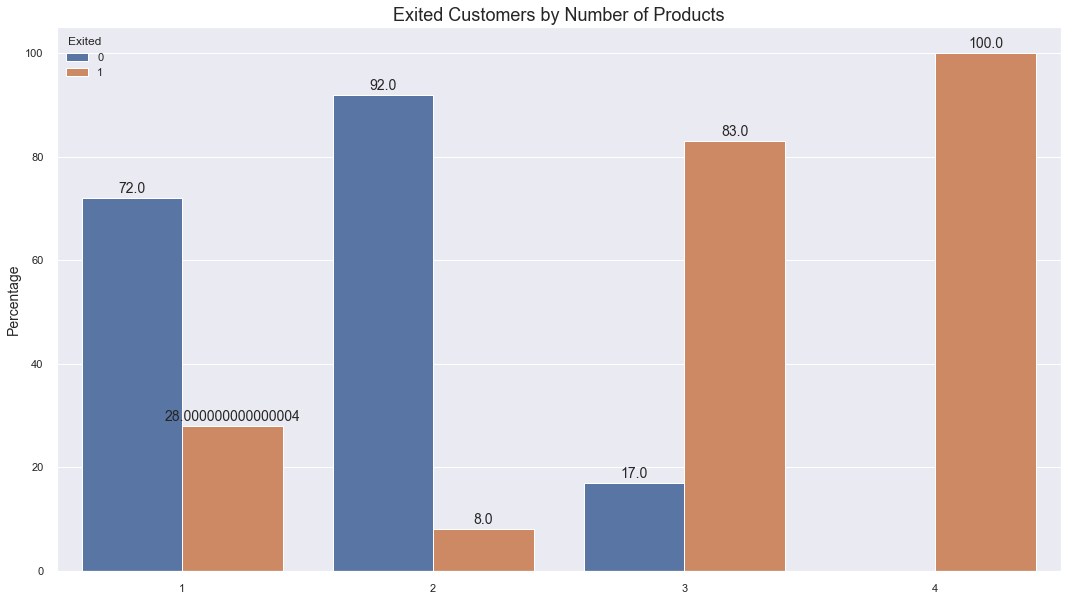

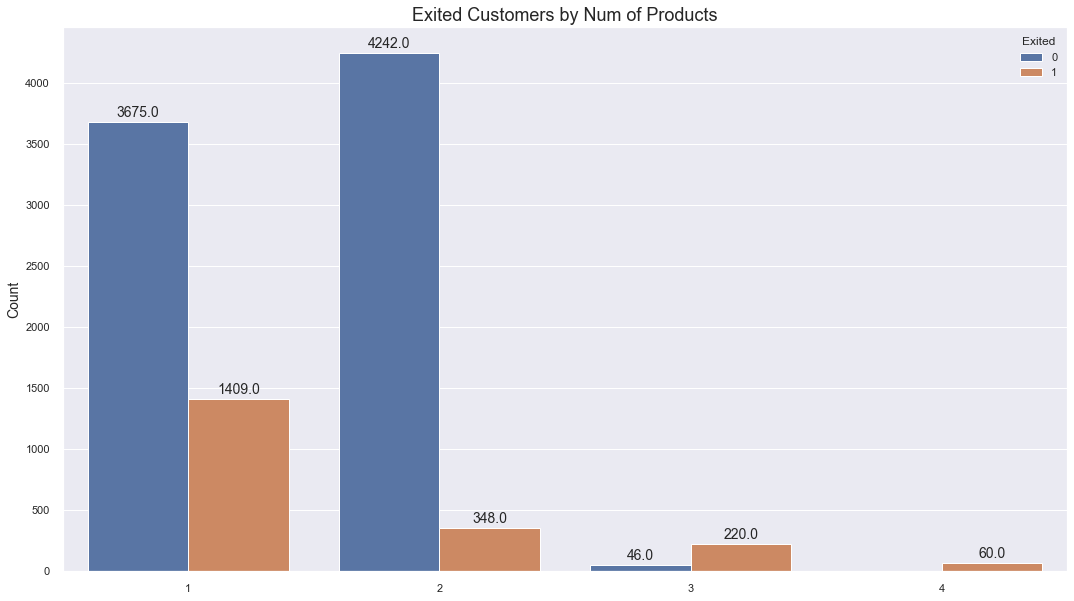

In [40]:
plt.subplots(1)

ax = sns.barplot('NumOfProducts', 'Percent', hue = 'Exited', data=df_prod)
ax.set_title('Exited Customers by Number of Products', fontsize = 18)
ax.set_xlabel('')
ax.set_ylabel('Percentage', fontsize=14)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot('NumOfProducts', 'Count',  hue = 'Exited', data=df_prod3)
ax2.set_title('Exited Customers by Num of Products', fontsize = 18)
ax2.set_xlabel('')
ax2.set_ylabel('Count', fontsize=14)
annot_plot(ax2)
;

**H5 Validation: FALSE**

    - Accordingly the data, customers with more products are more likely to exit.
        - 100% (60) customers with 4 products (higher) are exited, 83% of customers with 3 products are exited, only 8% of customers with 2 products are exited and 28% of customers with 1 prouct are exited. So customers with more products are more likely to be exited.

#### H6. Customer without creditcard are more likely to churn.

In [41]:
df_cc = df3.groupby(['HasCrCard'])['Exited'].value_counts(normalize=True).round(2)
df_cc = df_cc.mul(100).rename('Percent').reset_index()
df_cc2 = df3.groupby(['HasCrCard'])['Exited'].value_counts()
df_cc2 = pd.DataFrame(df_cc2).rename(columns = {'Exited':'Count'}).reset_index()

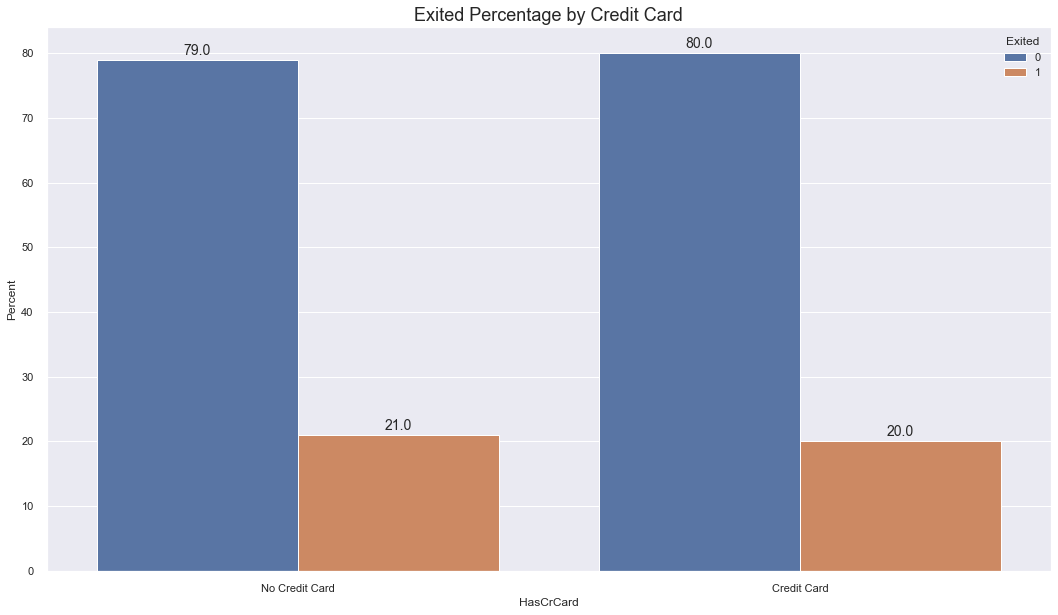

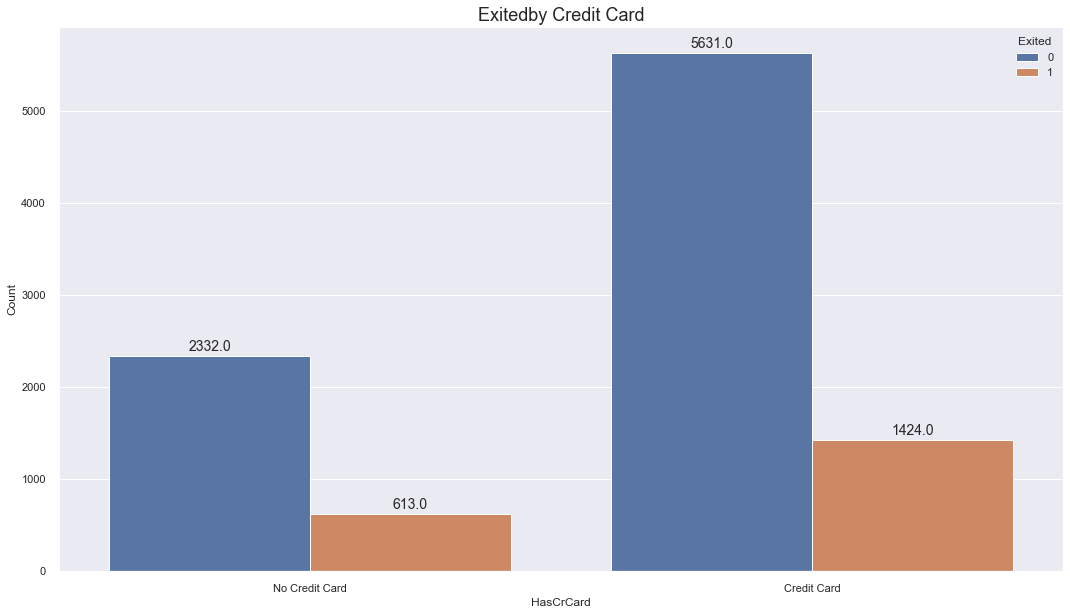

In [42]:
plt.subplots(1)

ax = sns.barplot(x = 'HasCrCard', y = 'Percent' ,hue = 'Exited', data = df_cc)
ax.set_xticklabels(['No Credit Card', 'Credit Card'])
ax.set_title('Exited Percentage by Credit Card', fontsize = 18)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot(x = 'HasCrCard', y = 'Count' ,hue = 'Exited', data = df_cc2)
ax2.set_xticklabels(['No Credit Card', 'Credit Card'])
ax2.set_title('Exitedby Credit Card', fontsize = 18)
annot_plot(ax2)

**H6 Validation: INCONCLUSIVE**

    - Accordingly the data, customers with and without credit card have the same behavior related to remain or not in the bank.
        - The difference between the has or not a credit card is not significant. 20% of customers with credit card has exited against 21% of customers without credit card.

#### H7. Active members are less likely to churn.

In [43]:
df_act = round(df3.groupby(['IsActiveMember'])['Exited'].value_counts(normalize=True),2)
df_act = df_act.mul(100).rename('Percent').reset_index()
df_act2 = df3.groupby(['IsActiveMember'])['Exited'].value_counts()
df_act2 = pd.DataFrame(df_act2).rename(columns = {'Exited':'Count'}).reset_index()

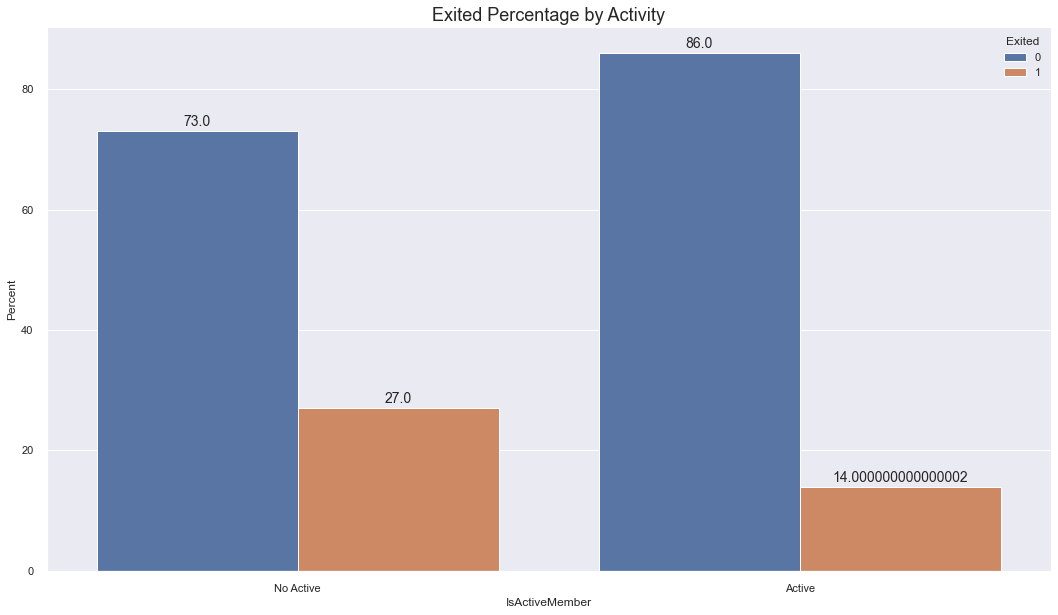

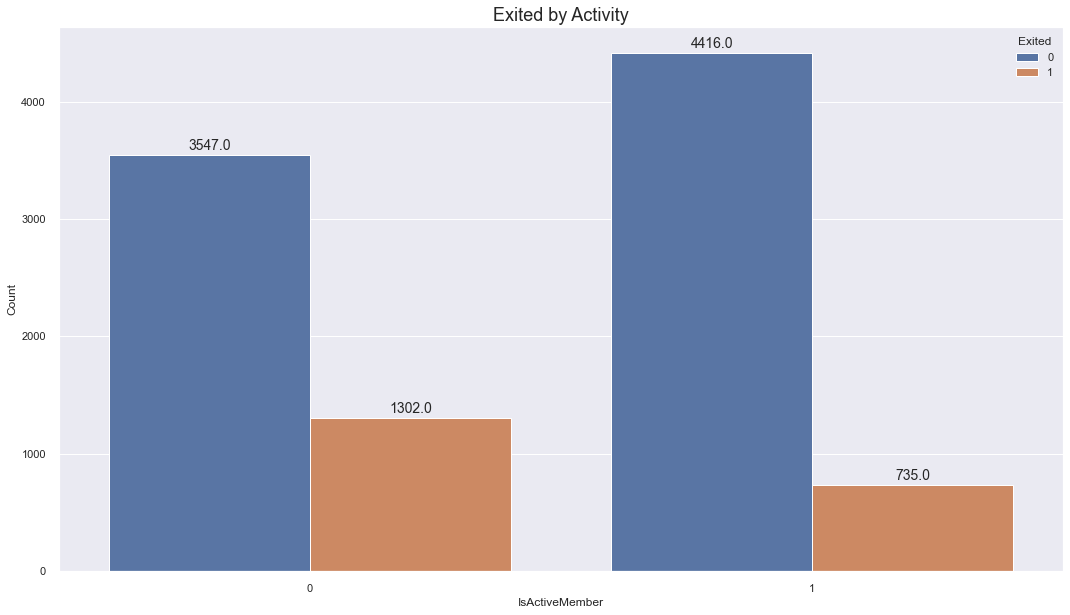

In [44]:
plt.subplots(1)

ax = sns.barplot(x = 'IsActiveMember', y = 'Percent' ,hue = 'Exited', data = df_act)
ax.set_xticklabels(['No Active', 'Active'])
ax.set_title('Exited Percentage by Activity', fontsize = 18)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot(x = 'IsActiveMember', y = 'Count' ,hue = 'Exited', data = df_act2)
ax.set_xticklabels(['No Active', 'Active'])
ax2.set_title('Exited by Activity', fontsize = 18)
annot_plot(ax2)

**H7 Validation: TRUE**

    - Accordingly the data, active members are more likely to remain, where only 14% are exited. Not active members have 27% of exited customers. 

#### H8. Customer with estimated salary bigger than the average are less likely to churn.

In [45]:
df_ms = round(df3.groupby(['MeanSalary'])['Exited'].value_counts(normalize=True),2)
df_ms = df_ms.mul(100).rename('Percent').reset_index()
df_ms2 = df3.groupby(['MeanSalary'])['Exited'].value_counts()
df_ms2 = pd.DataFrame(df_ms2).rename(columns = {'Exited':'Count'}).reset_index()

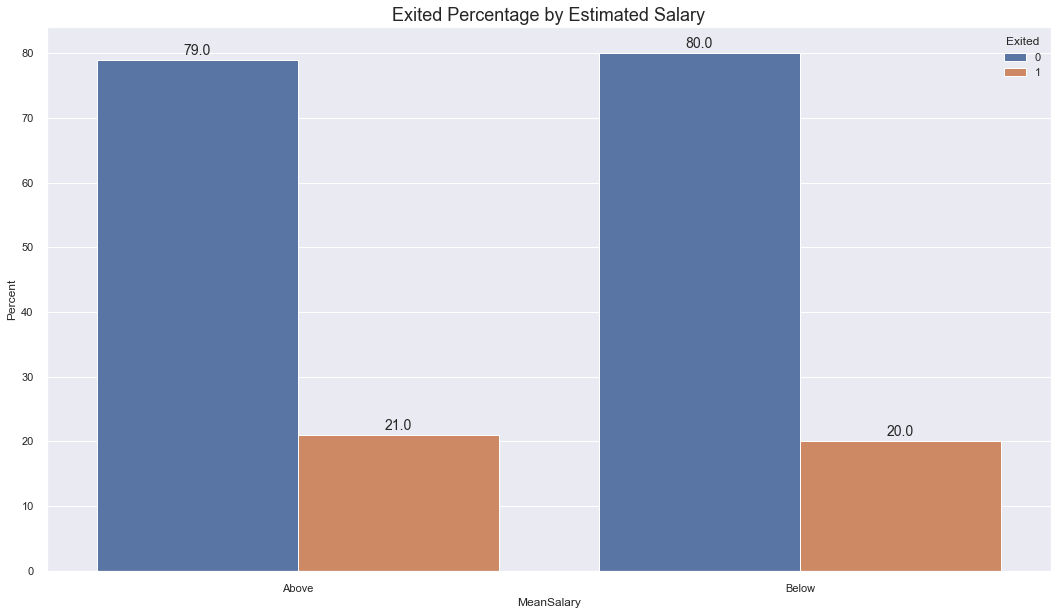

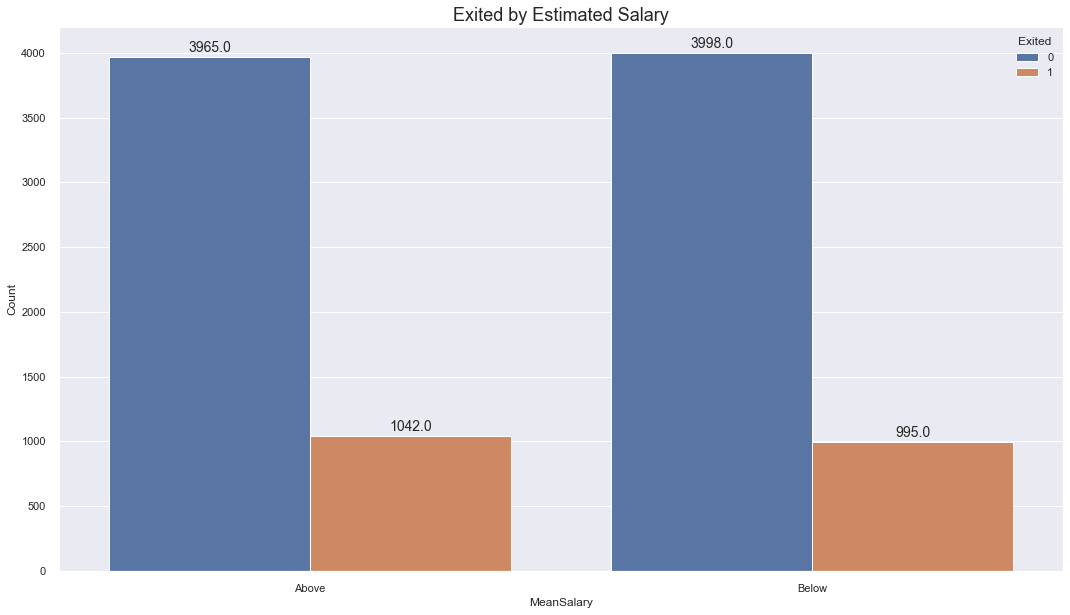

In [46]:
plt.subplots(1)

ax = sns.barplot(x = 'MeanSalary', y = 'Percent' ,hue = 'Exited', data = df_ms)
ax.set_title('Exited Percentage by Estimated Salary', fontsize = 18)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot(x = 'MeanSalary', y = 'Count' ,hue = 'Exited', data = df_ms2)
ax2.set_title('Exited by Estimated Salary', fontsize = 18)
annot_plot(ax2)

In [47]:
df_ms3 = round(df3.groupby(['CatEstSalary'])['Exited'].value_counts(normalize=True),2)
df_ms3 = df_ms3.mul(100).rename('Percent').reset_index()
df_ms4 = df3.groupby(['CatEstSalary'])['Exited'].value_counts()
df_ms4 = pd.DataFrame(df_ms4).rename(columns = {'Exited':'Count'}).reset_index()

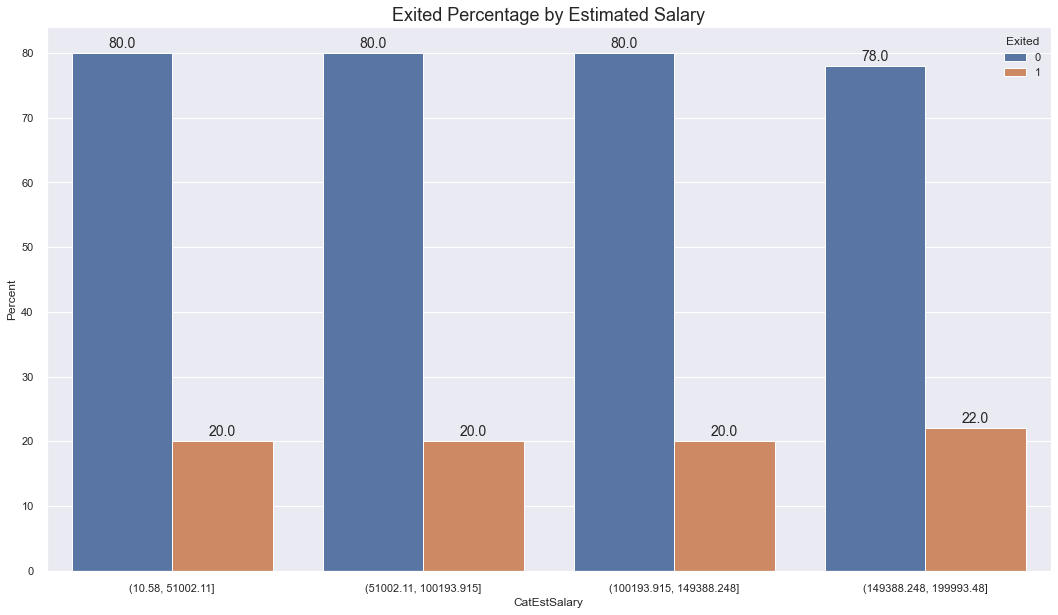

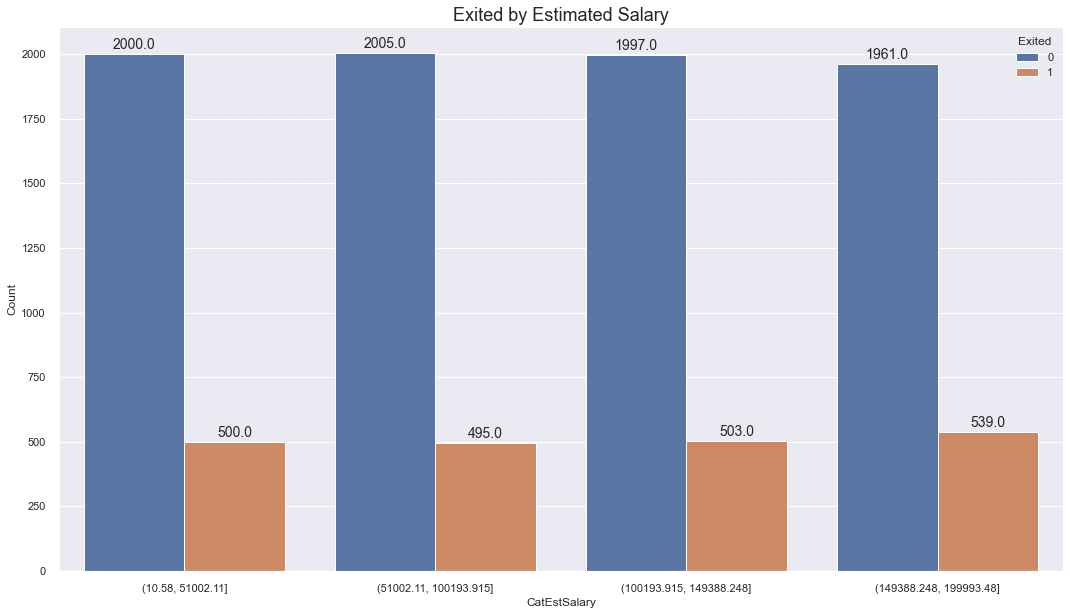

In [48]:
plt.subplots(1)

ax = sns.barplot(x = 'CatEstSalary', y = 'Percent' ,hue = 'Exited', data = df_ms3)
ax.set_title('Exited Percentage by Estimated Salary', fontsize = 18)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot(x = 'CatEstSalary', y = 'Count' ,hue = 'Exited', data = df_ms4)
ax2.set_title('Exited by Estimated Salary', fontsize = 18)
annot_plot(ax2)

**H8 Validation: INCONCLUSIVE**

    - Accordingly the data, the an estimated salary above or below the average has no influence if the customer will or will not remain as customer.
    - This is very weird, the data is very well balanced when it is divided in 4 accordingly with min, 25%, 50%, 75% and max estimated salary.

#### H9. Customers from which country are more likely to exit?

In [49]:
df_ct = round(df3.groupby(['Geography'])['Exited'].value_counts(normalize=True),2)
df_ct = df_ct.mul(100).rename('Percent').reset_index()
df_ct2 = df3.groupby(['Geography'])['Exited'].value_counts()
df_ct2 = pd.DataFrame(df_ct2).rename(columns = {'Exited':'Count'}).reset_index()

In [50]:
df_ct2

,Geography,Exited,Count
0,France,0,4204
1,France,1,810
2,Germany,0,1695
3,Germany,1,814
4,Spain,0,2064
5,Spain,1,413


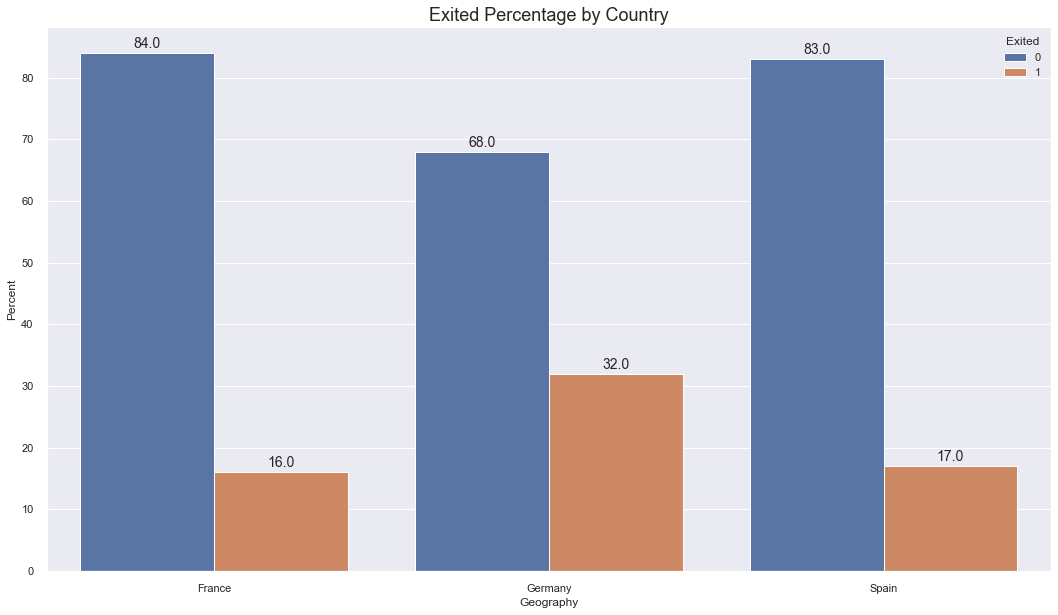

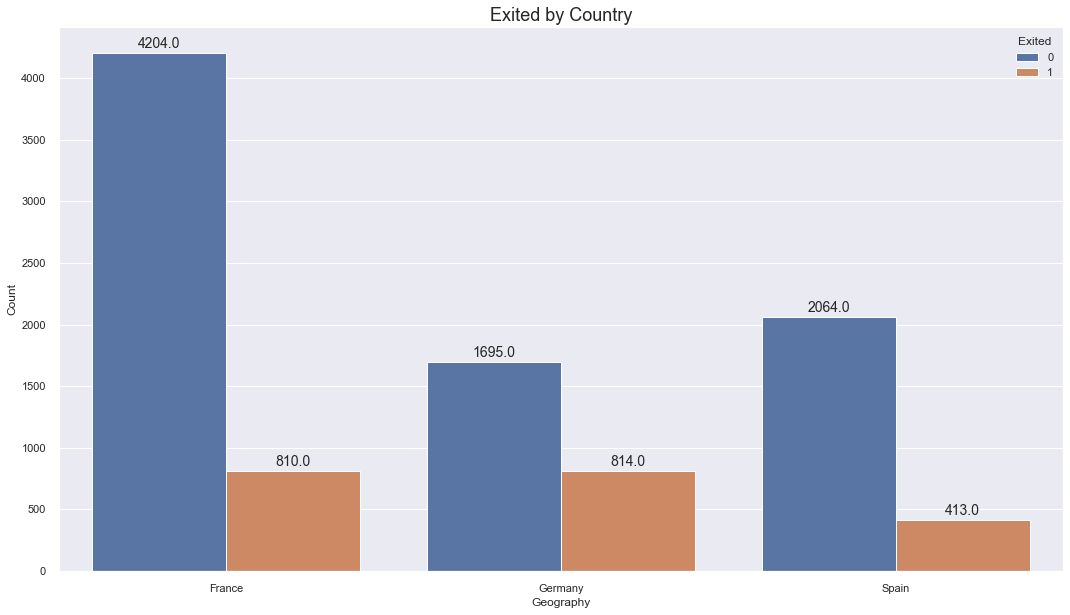

In [51]:
plt.subplots(1)

ax = sns.barplot(x = 'Geography', y = 'Percent' ,hue = 'Exited', data = df_ct)
ax.set_title('Exited Percentage by Country', fontsize = 18)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot(x = 'Geography', y = 'Count' ,hue = 'Exited', data = df_ct2)
ax2.set_title('Exited by Country', fontsize = 18)
annot_plot(ax2)

**H9: Germany**

    - Germany is by far the country with more exited customers, 32%, followed by Spain, 17% and France, 16%.

### Multivariated Analysis.

<AxesSubplot:>

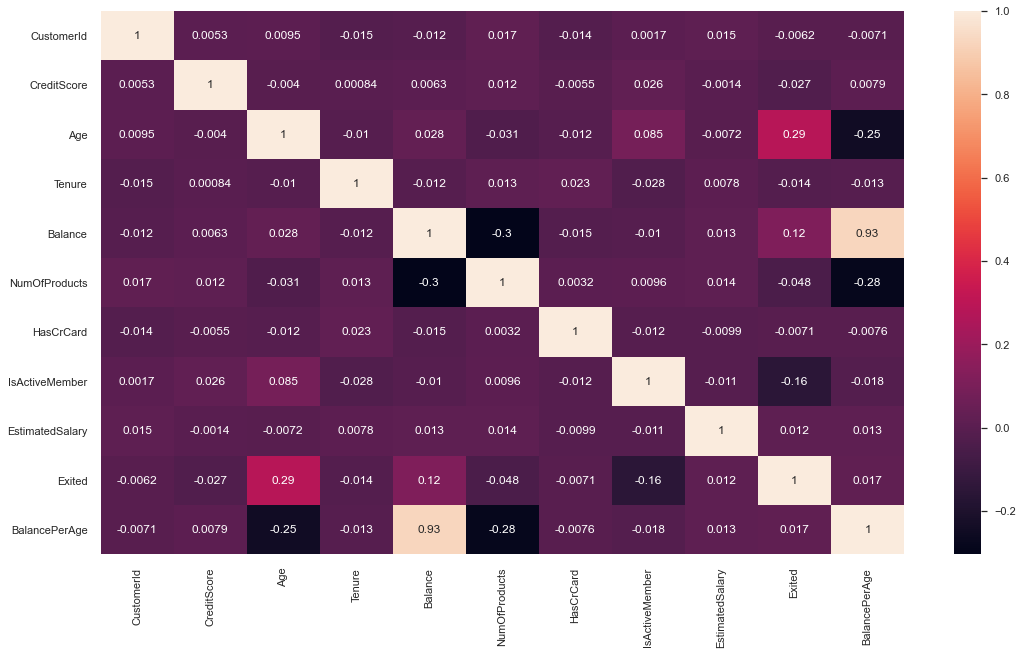

In [52]:
sns.heatmap(df3.corr(method='pearson'), annot=True)

## Data Preparation

In [373]:
# Excluded Columns - "Surname", "Balance", "Exited", "MeanSalary"
df4 = df3[
    ['CreditScore', 'Geography', 'Gender', 'Age','Tenure', 'Balance', 'NumOfProducts', 'HasCrCard','IsActiveMember','EstimatedSalary', 'Exited','BalanceCut', 'CatEstSalary', 'BalancePerAge']
]

In [374]:
# Separe DF
X = df4.drop('Exited', axis = 1)
y = df4['Exited']

# Split dataset into train and test
X_train_NB, X_test, y_train_NB, y_test = train_test_split(X, y, test_size=0.2, random_state=14, stratify=y)

df5 = pd.concat([X_train_NB, y_train_NB], axis=1)

### Encoding Categorical Variables

In [231]:
df5.dtypes

CreditScore           int64
Geography            object
Gender               object
Age                   int64
Tenure                int64
Balance             float64
NumOfProducts         int64
HasCrCard             int64
IsActiveMember        int64
EstimatedSalary     float64
BalanceCut         category
CatEstSalary       category
BalancePerAge       float64
Exited                int64
dtype: object

In [232]:
X_test_normal = X_test
# Encoding categorical features

# Geografphy
df5 = pd.get_dummies(df5, prefix = 'Geo', columns = ['Geography'])
X_test = pd.get_dummies(X_test, prefix = 'Geo', columns = ['Geography'])

# Gender
df5 = pd.get_dummies(df5, prefix='Gender', columns=['Gender'])
X_test = pd.get_dummies(X_test, prefix='Gender', columns=['Gender'])

# Has credit Card
df5 = pd.get_dummies(df5, prefix='HasCrCard', columns=['HasCrCard'])
X_test = pd.get_dummies(X_test, prefix='HasCrCard', columns=['HasCrCard'])

# is active member
df5 = pd.get_dummies(df5, prefix='IsActiveMember', columns=['IsActiveMember'])
X_test = pd.get_dummies(X_test, prefix='IsActiveMember', columns=['IsActiveMember'])


encoder = OrdinalEncoder()

# BalanceCut
df5['BalanceCut'] = encoder.fit_transform(np.array(df5['BalanceCut']).reshape(-1,1))
X_test['BalanceCut'] = encoder.fit_transform(np.array(X_test['BalanceCut']).reshape(-1,1))

# CatEstSalary
df5['CatEstSalary'] = encoder.fit_transform(np.array(df5['CatEstSalary']).reshape(-1,1))
X_test['CatEstSalary'] = encoder.fit_transform(np.array(X_test['CatEstSalary']).reshape(-1,1))

# Num of products
df5['NumOfProducts'] = encoder.fit_transform(np.array(df5['NumOfProducts']).reshape(-1,1))
X_test['NumOfProducts'] = encoder.fit_transform(np.array(X_test['NumOfProducts']).reshape(-1,1))

### Rescaling numerical features.

#### StandardScaler

In [57]:
# Credit Score - distribution close to a normal.

ss = StandardScaler()
df5['CreditScore'] = ss.fit_transform(df5[['CreditScore']].values)
X_test['CreditScore'] = ss.fit_transform(X_test[['CreditScore']].values)

#### MinMaxScaler

In [58]:
mms = MinMaxScaler()

# Age
df5['Age'] = mms.fit_transform(df5[['Age']].values)
X_test['Age'] = mms.fit_transform(X_test[['Age']].values)

# Tenure
df5['Tenure'] = mms.fit_transform(df5[['Tenure']].values)
X_test['Tenure'] = mms.fit_transform(X_test[['Tenure']].values)

# Balance
df5['Balance'] = mms.fit_transform(df5[['Balance']].values)
X_test['Balance'] = mms.fit_transform(X_test[['Balance']].values)

# Estimated Salary
df5['EstimatedSalary'] = mms.fit_transform(df5[['EstimatedSalary']].values)
X_test['EstimatedSalary'] = mms.fit_transform(X_test[['EstimatedSalary']].values)

# balance Per Age
df5['BalancePerAge'] = mms.fit_transform(df5[['BalancePerAge']].values)
X_test['BalancePerAge'] = mms.fit_transform(X_test[['BalancePerAge']].values)


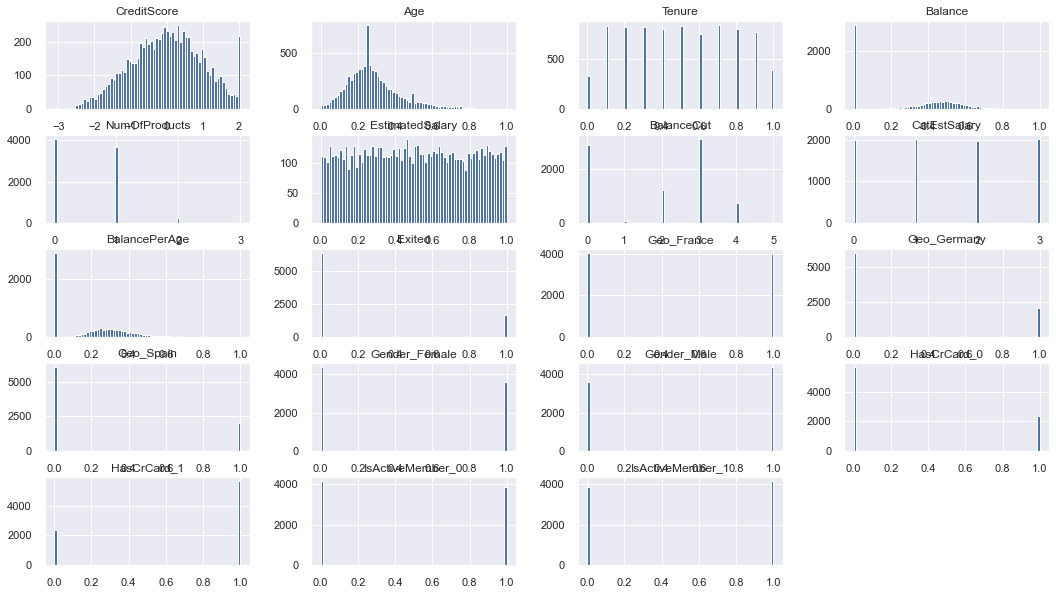

In [59]:
df5.hist(bins=70);

#### Data Balancing

In [60]:
# Apply SMOTE tomek links method - balancing.
X_train_NB = df5.drop('Exited', axis = 1)
y_train_NB = df5['Exited']

st = SMOTETomek(random_state=14, n_jobs=-1)

X_train, y_train = st.fit_resample(X_train_NB, y_train_NB)

In [61]:
X_train.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary', 'BalanceCut', 'CatEstSalary', 'BalancePerAge',
       'Geo_France', 'Geo_Germany', 'Geo_Spain', 'Gender_Female',
       'Gender_Male', 'HasCrCard_0', 'HasCrCard_1', 'IsActiveMember_0',
       'IsActiveMember_1'],
      dtype='object')

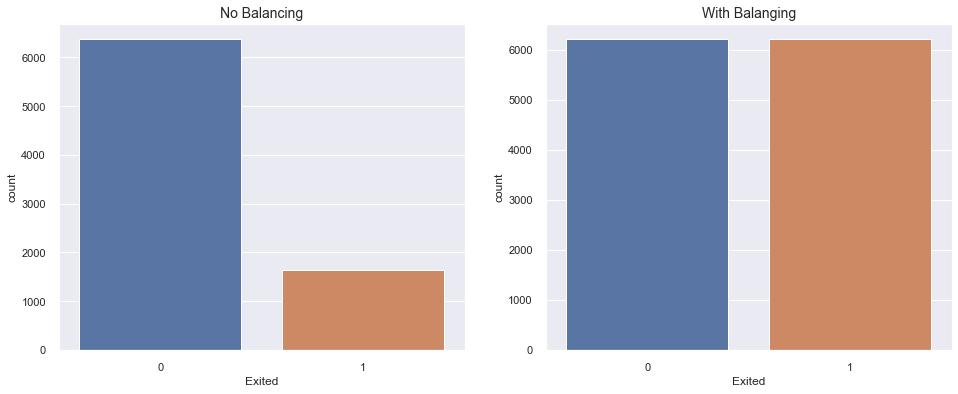

In [62]:
# Plot before and after balancing

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.countplot(x=y_train_NB).set_title('No Balancing', fontsize=14)

plt.subplot(1,2,2)
sns.countplot(x=y_train).set_title('With Balanging', fontsize=14);

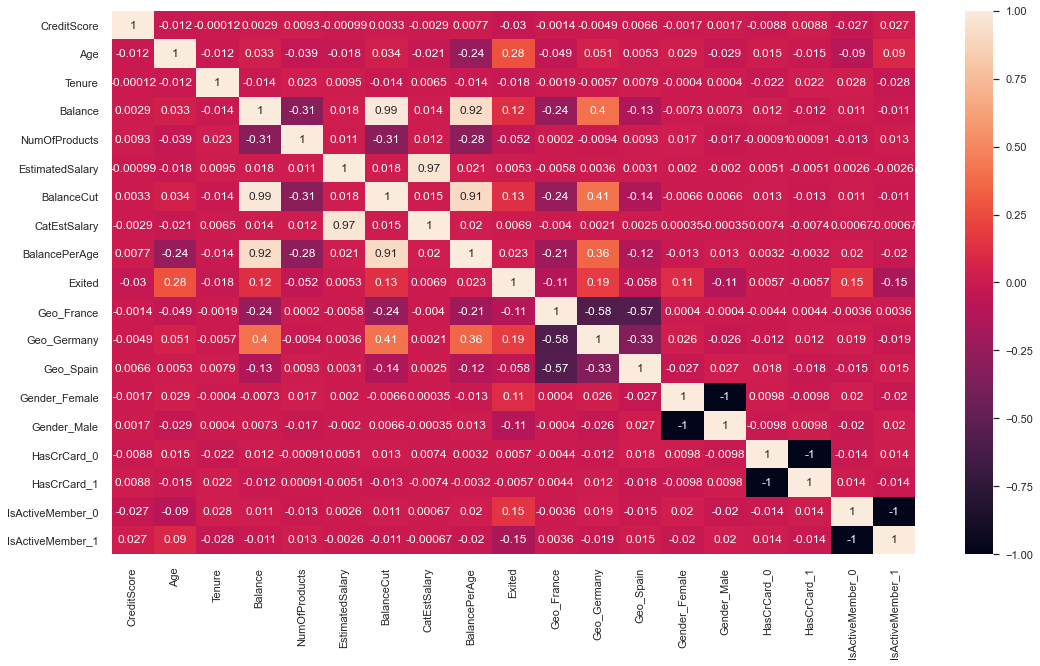

In [63]:
# Correlation Heatmap

sns.heatmap(df5.corr(), annot=True);

## Feature Selection Randon Forest

In [64]:
# Model definition
RFC = RandomForestClassifier()

RFC.fit(X_train, y_train.values)

RandomForestClassifier()

In [65]:
imp = RFC.feature_importances_

std = np.std([tree.feature_importances_ for tree in RFC.estimators_], axis=0)
indices = np.argsort(imp)[::-1]

print('Features Ranking:')
df = pd.DataFrame()
for i, j in zip(X_train, RFC.feature_importances_):
    aux = pd.DataFrame({'Feature': i, 'Importance': j * 100}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('Importance', ascending=False))

Features Ranking:
            Feature  Importance
0               Age   22.921694
0     NumOfProducts   17.319278
0       CreditScore    7.908137
0     BalancePerAge    7.729091
0   EstimatedSalary    7.726230
0           Balance    7.533693
0            Tenure    7.049918
0        BalanceCut    4.327286
0      CatEstSalary    3.239703
0       Geo_Germany    2.797517
0  IsActiveMember_1    2.596673
0  IsActiveMember_0    1.645054
0       Gender_Male    1.520418
0        Geo_France    1.395470
0         Geo_Spain    1.289831
0     Gender_Female    1.056871
0       HasCrCard_1    1.007982
0       HasCrCard_0    0.935153


In [66]:
X_cv = X_train.append(X_test)
y_cv = y_train.append(y_test)

## Machine Learning Modeling

### Random Forest Classifier

In [132]:
# Test evaluation
RFC = RandomForestClassifier(random_state=14, n_jobs=-1)

RFC_eval_model = model_eval('Random Forest Classifier', RFC, X_train, X_test, y_train, y_test)
RFC_eval_model

,Balanced_Accuracy,Precision,Recall,F1_Score,ROC_AUC,MCC,Kappa_Score
Random Forest Classifier,0.742531,0.609819,0.579853,0.594458,0.742531,0.494345,0.494101


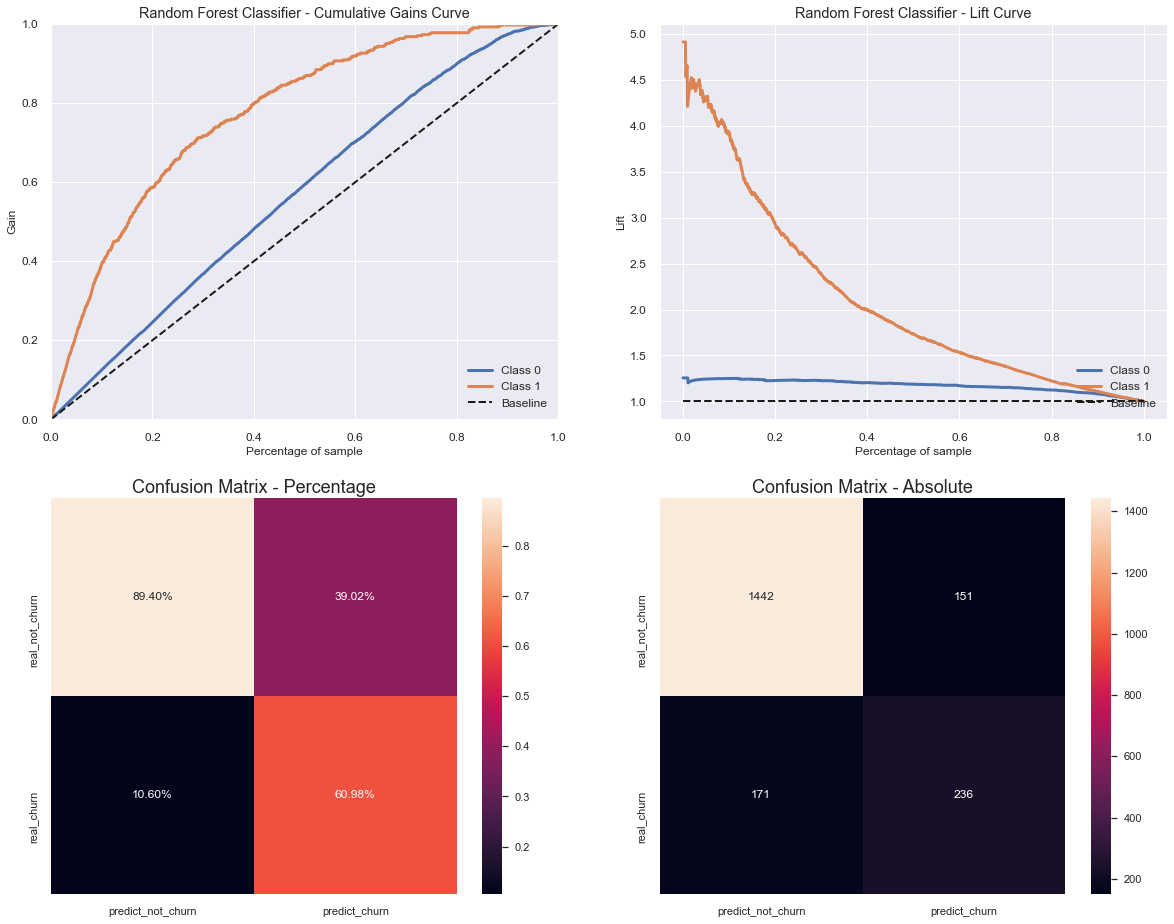

In [68]:
y_proba_RFC = RFC.predict_proba(X_test)
y_hat_RFC = RFC.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_hat_RFC),
                  columns=['predict_not_churn', 'predict_churn'],
                  index=['real_not_churn', 'real_churn'])

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

plot_cumulative_gain(y_test, y_proba_RFC, title='Random Forest Classifier - Cumulative Gains Curve', ax=ax1)

plot_lift_curve(y_test, y_proba_RFC, title='Random Forest Classifier - Lift Curve', ax=ax2)

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', ax=ax3).set_title('Confusion Matrix - Percentage', fontsize = 18)

sns.heatmap(cm, annot=True, fmt='d', ax=ax4).set_title('Confusion Matrix - Absolute', fontsize = 18);

### Cat Boost Classifier

In [84]:
CBC = CatBoostClassifier(random_state=14, verbose=False)

CBC_eval_model = model_eval('Cat Boost Classifier', CBC, X_train, X_test, y_train, y_test)
CBC_eval_model

,Balanced_Accuracy,Precision,Recall,F1_Score,ROC_AUC,MCC,Kappa_Score
Cat Boost Classifier,0.723199,0.66881,0.511057,0.579387,0.723199,0.495944,0.489367


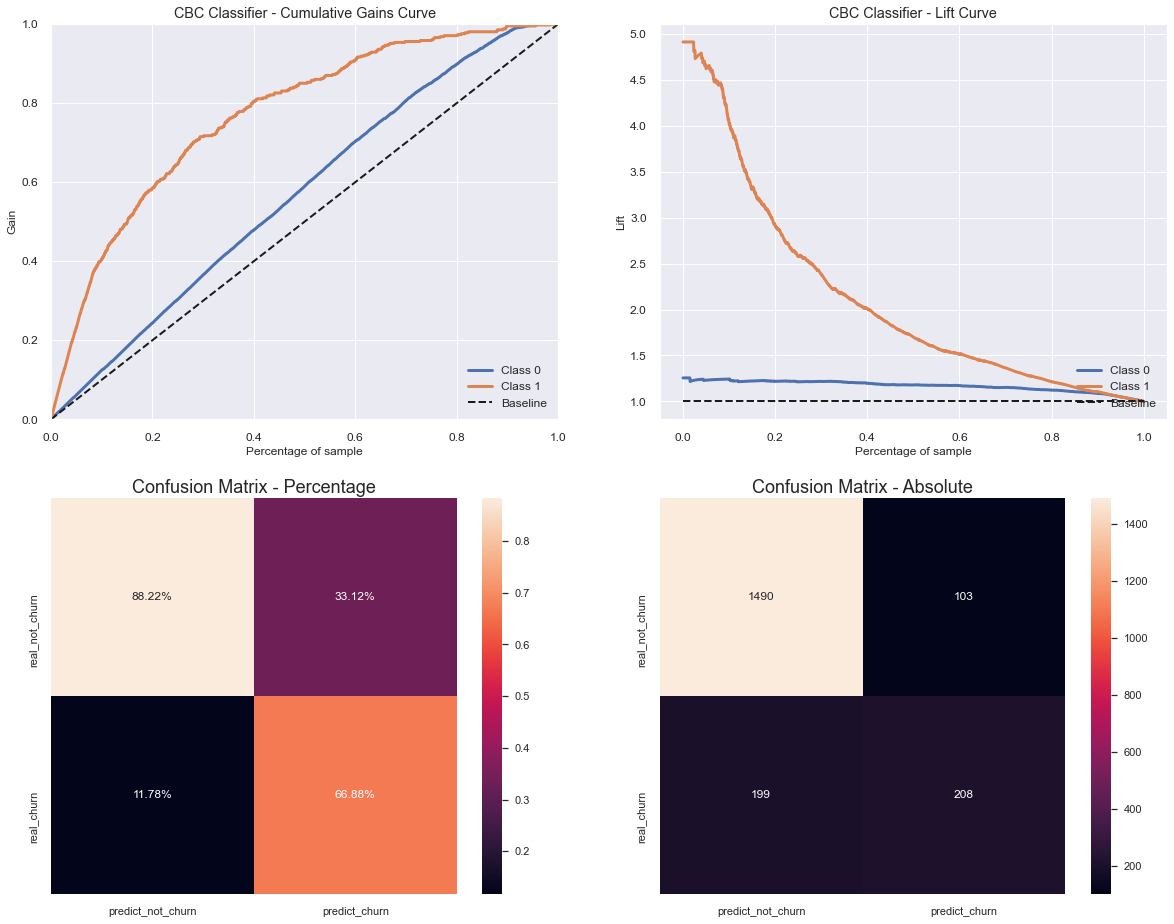

In [85]:
y_proba_CBC = CBC.predict_proba(X_test)
y_hat_CBC = CBC.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_hat_CBC),
                  columns=['predict_not_churn', 'predict_churn'],
                  index=['real_not_churn', 'real_churn'])

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
plot_cumulative_gain(y_test, y_proba_CBC, title='CBC Classifier - Cumulative Gains Curve', ax=ax1)

plot_lift_curve(y_test, y_proba_CBC, title='CBC Classifier - Lift Curve', ax=ax2)

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', ax=ax3).set_title('Confusion Matrix - Percentage', fontsize = 18)

sns.heatmap(cm, annot=True, fmt='d', ax=ax4).set_title('Confusion Matrix - Absolute', fontsize = 18);

### LGBM

In [76]:
LGBM = LGBMClassifier(random_state=14)
                     

LGBM_eval_model = model_eval('LGBM', LGBM, X_train, X_test, y_train, y_test)
LGBM_eval_model

,Balanced_Accuracy,Precision,Recall,F1_Score,ROC_AUC,MCC,Kappa_Score
LGBM,0.73543,0.664653,0.540541,0.596206,0.73543,0.5101,0.506036


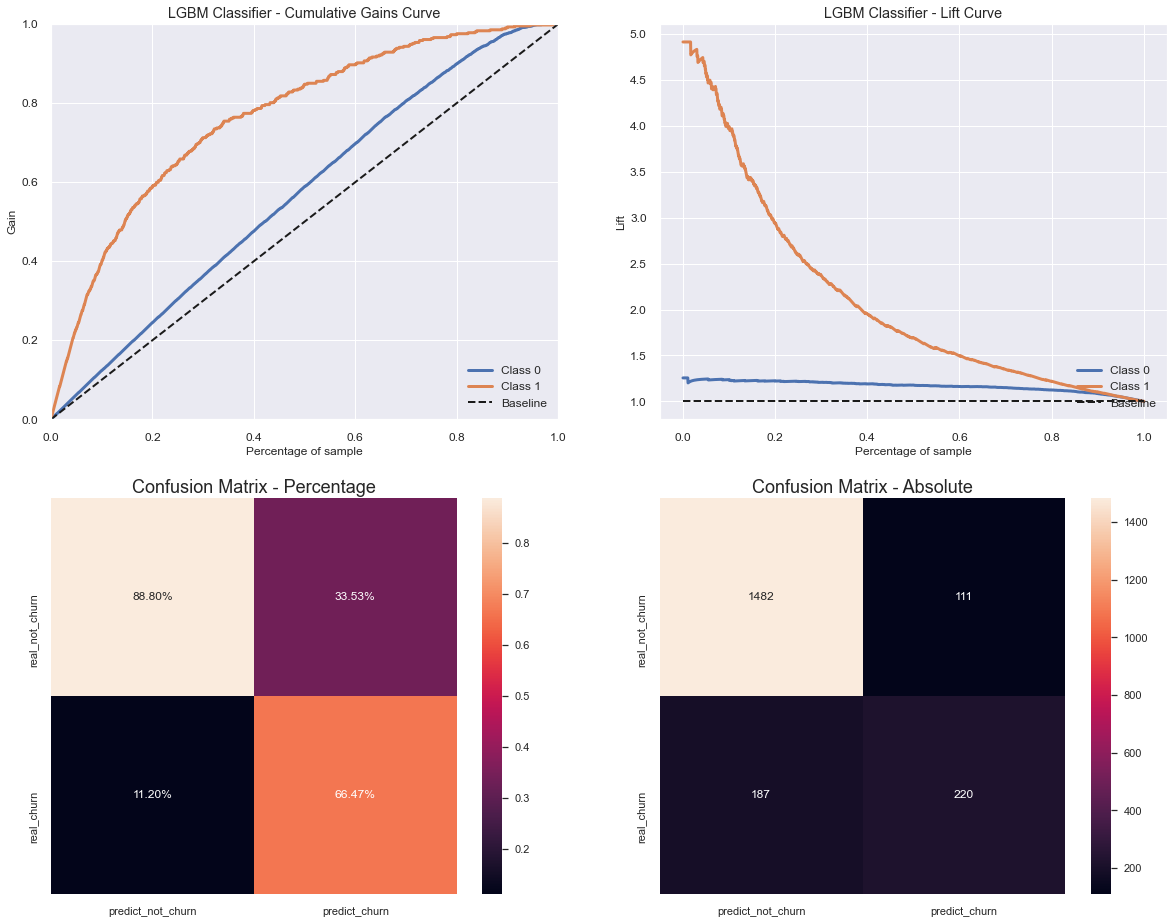

In [77]:
y_proba_LGBM = LGBM.predict_proba(X_test)
y_hat_LGBM = LGBM.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_hat_LGBM),
                  columns=['predict_not_churn', 'predict_churn'],
                  index=['real_not_churn', 'real_churn'])

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
plot_cumulative_gain(y_test, y_proba_LGBM, title='LGBM Classifier - Cumulative Gains Curve', ax=ax1)

plot_lift_curve(y_test, y_proba_LGBM, title='LGBM Classifier - Lift Curve', ax=ax2)

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', ax=ax3).set_title('Confusion Matrix - Percentage', fontsize = 18)

sns.heatmap(cm, annot=True, fmt='d', ax=ax4).set_title('Confusion Matrix - Absolute', fontsize = 18);

### Comparison of the generalization of the selected models (test data) - Random Forest Classifier, Cat Boost Classifier and LGBM Classifier.

In [83]:
model_comparison = RFC_eval_model
model_comparison = model_comparison.append(CBC_eval_model)
model_comparison = model_comparison.append(LGBM_eval_model)
model_comparison.reset_index(inplace=True)
model_comparison = model_comparison.style.highlight_max(color='cornflowerblue')
model_comparison

,index,Balanced_Accuracy,Precision,Recall,F1_Score,ROC_AUC,MCC,Kappa_Score
0,Random Forest Classifier,0.742531,0.609819,0.579853,0.594458,0.742531,0.494345,0.494101
1,Cat Boost Classifier,0.723199,0.668810,0.511057,0.579387,0.723199,0.495944,0.489367
2,LGBM,0.735430,0.664653,0.540541,0.596206,0.735430,0.510100,0.506036


## ML Fine Tuning

### Random Forest Classifier fine tuning.

In [134]:
parameters = {
    'n_estimators': [75, 150, 200, 300, 400],
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [1, 2, 3, 4, 5],
    'bootstrap': [True, False]
}
scoring = ['balanced_accuracy', 'f1', 'recall', 'roc_auc', 'precision']
params = {}

for score in scoring: 
    RSCV_RFC = RandomizedSearchCV(RFC, param_distributions = parameters, scoring = score, refit=False, return_train_score=True)
    RSCV_RFC.fit(X_train, y_train)
    
    params[score] = RSCV_RFC.best_params_
    
params

{'balanced_accuracy': {'n_estimators': 400,
  'min_samples_split': 3,
  'max_depth': 12,
  'criterion': 'entropy',
  'bootstrap': False},
 'f1': {'n_estimators': 150,
  'min_samples_split': 3,
  'max_depth': 12,
  'criterion': 'gini',
  'bootstrap': False},
 'recall': {'n_estimators': 400,
  'min_samples_split': 3,
  'max_depth': 12,
  'criterion': 'gini',
  'bootstrap': True},
 'roc_auc': {'n_estimators': 300,
  'min_samples_split': 3,
  'max_depth': 12,
  'criterion': 'entropy',
  'bootstrap': True},
 'precision': {'n_estimators': 400,
  'min_samples_split': 4,
  'max_depth': 12,
  'criterion': 'gini',
  'bootstrap': False}}

In [136]:
pd.DataFrame(params).T

,n_estimators,min_samples_split,max_depth,criterion,bootstrap
balanced_accuracy,400,3,12,entropy,False
f1,150,3,12,gini,False
recall,400,3,12,gini,True
roc_auc,300,3,12,entropy,True
precision,400,4,12,gini,False


In [147]:
RSCV_RFC.best_score_

0.8885360387990463

In [148]:
RSCV_RFC.best_params_

{'n_estimators': 400,
 'min_samples_split': 4,
 'max_depth': 12,
 'criterion': 'gini',
 'bootstrap': False}

In [192]:
RFC = RandomForestClassifier(random_state=14, 
                             n_jobs=-1,
                             n_estimators = 400,
                             min_samples_split = 2,
                             max_depth = 8,
                             criterion = 'gini',
                             bootstrap = True)

RFC_eval_model_RSCV = model_eval('RSCV Random Forest Classifier', RFC, X_train, X_test, y_train, y_test)
RFC_EV = RFC_eval_model.append(RFC_eval_model_RSCV)
RFC_EV

,Balanced_Accuracy,Precision,Recall,F1_Score,ROC_AUC,MCC,Kappa_Score
Random Forest Classifier,0.742531,0.609819,0.579853,0.594458,0.742531,0.494345,0.494101
RSCV Random Forest Classifier,0.766410,0.564854,0.663391,0.610169,0.766410,0.502995,0.500329


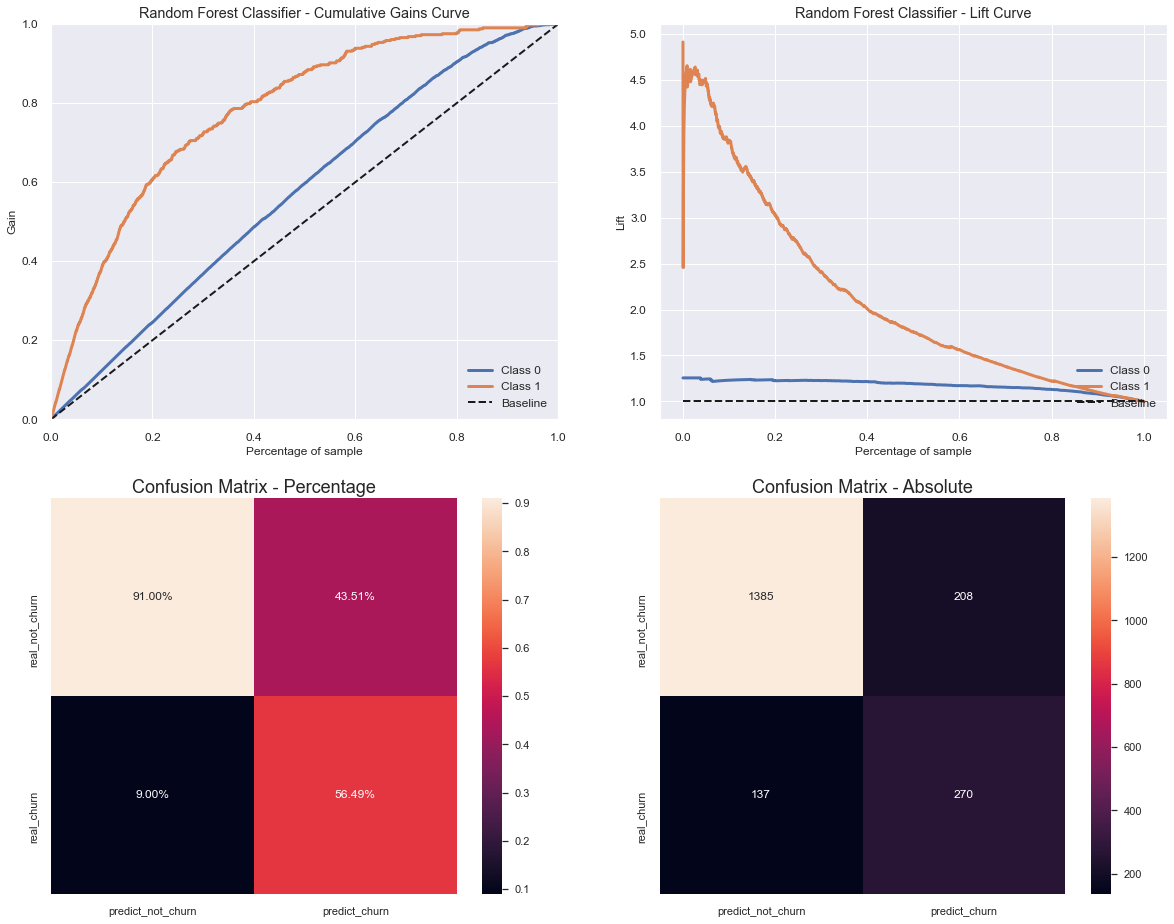

In [198]:
y_proba_RFC_FT = RFC.predict_proba(X_test)
y_hat_RFC_FT = RFC.predict(X_test)

cm_RF = pd.DataFrame(confusion_matrix(y_test, y_hat_RFC_FT),
                  columns=['predict_not_churn', 'predict_churn'],
                  index=['real_not_churn', 'real_churn'])

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

plot_cumulative_gain(y_test, y_proba_RFC_FT, title='Random Forest Classifier - Cumulative Gains Curve', ax=ax1)

plot_lift_curve(y_test, y_proba_RFC_FT, title='Random Forest Classifier - Lift Curve', ax=ax2)

sns.heatmap(cm_RF/np.sum(cm_RF), annot=True, fmt='.2%', ax=ax3).set_title('Confusion Matrix - Percentage', fontsize = 18)

sns.heatmap(cm_RF, annot=True, fmt='d', ax=ax4).set_title('Confusion Matrix - Absolute', fontsize = 18);

### Cat Boost Classifier - fine tuning

In [145]:
parameters = {
    'depth': [4, 5, 6, 7],
    'eval_metric': ['BalancedAccuracy'],
    'iterations': [400, 500, 600],
    'learning_rate': [0.05, 0.065, 0.07, 0.075, 0.08],
    'random_state': [14], 
    'verbose': [False]
}
scoring = ['balanced_accuracy', 'f1', 'recall', 'roc_auc', 'precision']
GSCV_CBC = GridSearchCV(CBC, param_grid = parameters, scoring = 'recall', refit=False, return_train_score=True)
GSCV_CBC.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x00000140516ACCD0>,
             param_grid={'depth': [4, 5, 6, 7],
                         'eval_metric': ['BalancedAccuracy'],
                         'iterations': [400, 500, 600],
                         'learning_rate': [0.05, 0.065, 0.07, 0.075, 0.08],
                         'random_state': [14], 'verbose': [False]},
             refit=False, return_train_score=True, scoring='recall')

In [146]:
GSCV_CBC.best_params_

{'depth': 7,
 'eval_metric': 'BalancedAccuracy',
 'iterations': 400,
 'learning_rate': 0.08,
 'random_state': 14,
 'verbose': False}

In [193]:
CBC = CatBoostClassifier(random_state=14,
                         verbose=False,
                         depth = 7,
                         eval_metric = 'BalancedAccuracy',
                         iterations = 400,
                         learning_rate = 0.1)
 
CBC_eval_model_RSCV = model_eval('RSCV Cat Boost Classifier', CBC, X_train, X_test, y_train, y_test)
CBC_EV = CBC_eval_model.append(CBC_eval_model_RSCV)
CBC_EV

,Balanced_Accuracy,Precision,Recall,F1_Score,ROC_AUC,MCC,Kappa_Score
Cat Boost Classifier,0.723199,0.668810,0.511057,0.579387,0.723199,0.495944,0.489367
RSCV Cat Boost Classifier,0.734050,0.707641,0.523342,0.601695,0.734050,0.527064,0.518355


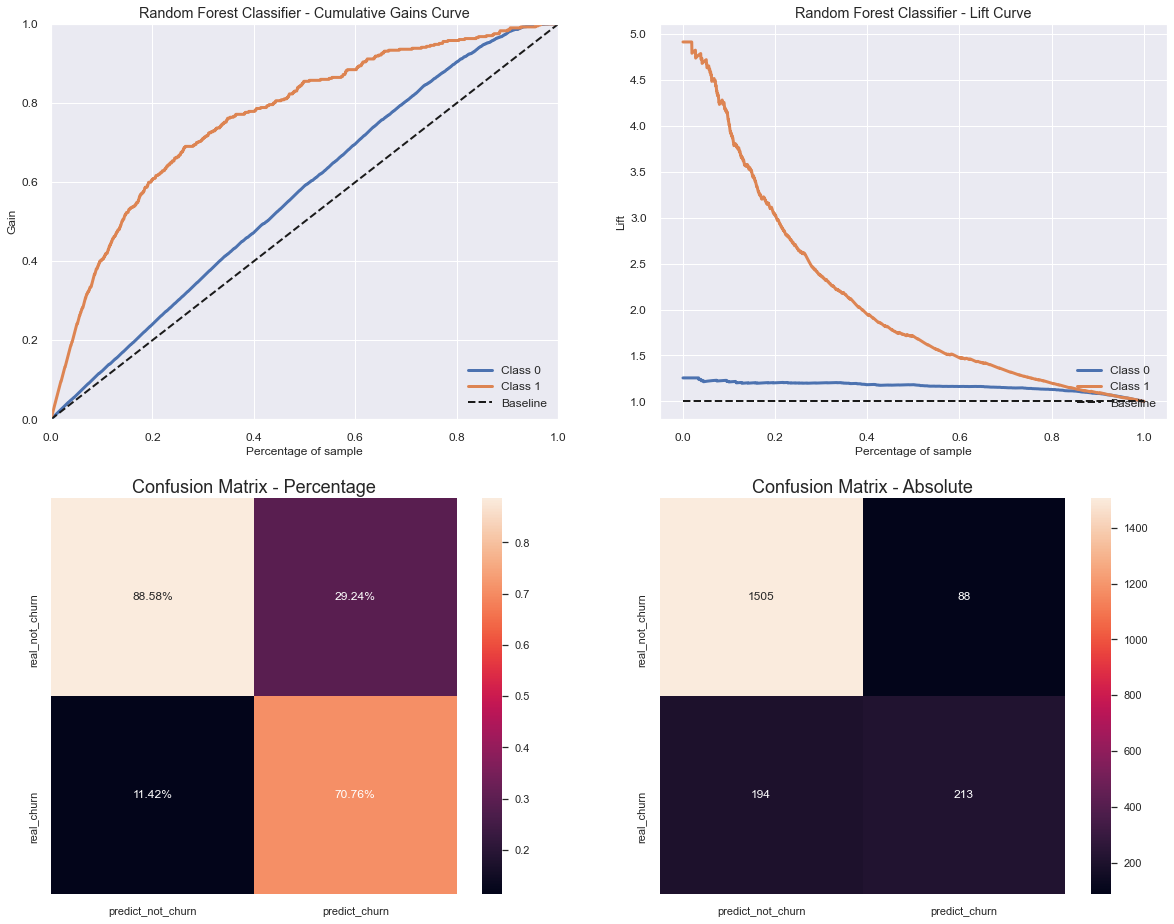

In [199]:
y_proba_CBC_FT = CBC.predict_proba(X_test)
y_hat_CBC_FT = CBC.predict(X_test)

cm_CB = pd.DataFrame(confusion_matrix(y_test, y_hat_CBC_FT),
                  columns=['predict_not_churn', 'predict_churn'],
                  index=['real_not_churn', 'real_churn'])

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

plot_cumulative_gain(y_test, y_proba_CBC_FT, title='Random Forest Classifier - Cumulative Gains Curve', ax=ax1)

plot_lift_curve(y_test, y_proba_CBC_FT, title='Random Forest Classifier - Lift Curve', ax=ax2)

sns.heatmap(cm_CB/np.sum(cm_CB), annot=True, fmt='.2%', ax=ax3).set_title('Confusion Matrix - Percentage', fontsize = 18)

sns.heatmap(cm_CB, annot=True, fmt='d', ax=ax4).set_title('Confusion Matrix - Absolute', fontsize = 18);

### LGBM Classifier - fine tuning

In [161]:
LGBM = LGBMClassifier(random_state=14)

parameters = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'n_estimators': [75, 150, 200, 300, 400],
    'max_depth': [4, 8, 10, 15, 20, 30],
    'max_bin':[20, 50, 90]
}
scoring = ['balanced_accuracy', 'f1', 'recall', 'roc_auc', 'precision']

RSCV_LGBM = RandomizedSearchCV(LGBM, param_distributions = parameters, scoring = 'balanced_accuracy', refit=False, return_train_score=True)
RSCV_LGBM.fit(X_train, y_train)

RSCV_LGBM.best_params_

{'n_estimators': 400, 'max_depth': 8, 'max_bin': 20, 'learning_rate': 0.1}

In [195]:
LGBM = LGBMClassifier(random_state=14,
                      n_estimators = 400,
                      max_depth = 15,
                      max_bin = 100,
                      learning_rate = 0.01)
                     

LGBM_eval_model_RSCV = model_eval('RSCV LGBM', LGBM, X_train, X_test, y_train, y_test)
LGBM_EV = LGBM_eval_model.append(LGBM_eval_model_RSCV)
LGBM_EV

,Balanced_Accuracy,Precision,Recall,F1_Score,ROC_AUC,MCC,Kappa_Score
LGBM,0.73543,0.664653,0.540541,0.596206,0.73543,0.510100,0.506036
RSCV LGBM,0.74941,0.640541,0.582310,0.610039,0.74941,0.517194,0.516291


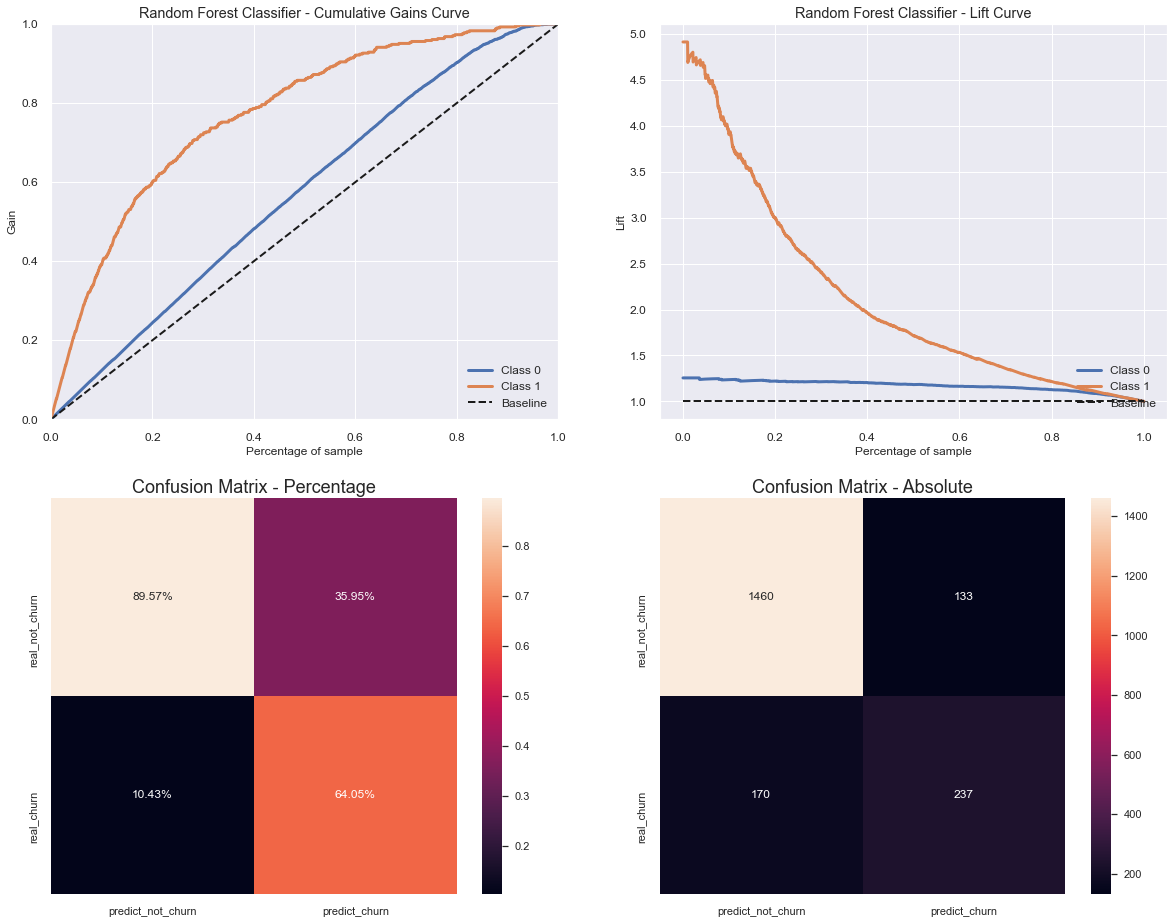

In [200]:
y_proba_LGBM_FT = LGBM.predict_proba(X_test)
y_hat_LGBM_FT = LGBM.predict(X_test)

cm_LGBM = pd.DataFrame(confusion_matrix(y_test, y_hat_LGBM_FT),
                  columns=['predict_not_churn', 'predict_churn'],
                  index=['real_not_churn', 'real_churn'])

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

plot_cumulative_gain(y_test, y_proba_LGBM_FT, title='Random Forest Classifier - Cumulative Gains Curve', ax=ax1)

plot_lift_curve(y_test, y_proba_LGBM_FT, title='Random Forest Classifier - Lift Curve', ax=ax2)

sns.heatmap(cm_LGBM/np.sum(cm_LGBM), annot=True, fmt='.2%', ax=ax3).set_title('Confusion Matrix - Percentage', fontsize = 18)

sns.heatmap(cm_LGBM, annot=True, fmt='d', ax=ax4).set_title('Confusion Matrix - Absolute', fontsize = 18);

## Final Model Comparison

In [197]:
final_comp = RFC_EV.append(CBC_EV)
final_comp = final_comp.append(LGBM_EV).style.highlight_max(color='cornflowerblue')
final_comp

,Balanced_Accuracy,Precision,Recall,F1_Score,ROC_AUC,MCC,Kappa_Score
Random Forest Classifier,0.742531,0.609819,0.579853,0.594458,0.742531,0.494345,0.494101
RSCV Random Forest Classifier,0.766410,0.564854,0.663391,0.610169,0.766410,0.502995,0.500329
Cat Boost Classifier,0.723199,0.668810,0.511057,0.579387,0.723199,0.495944,0.489367
RSCV Cat Boost Classifier,0.734050,0.707641,0.523342,0.601695,0.734050,0.527064,0.518355
LGBM,0.735430,0.664653,0.540541,0.596206,0.735430,0.510100,0.506036
RSCV LGBM,0.749410,0.640541,0.582310,0.610039,0.749410,0.517194,0.516291


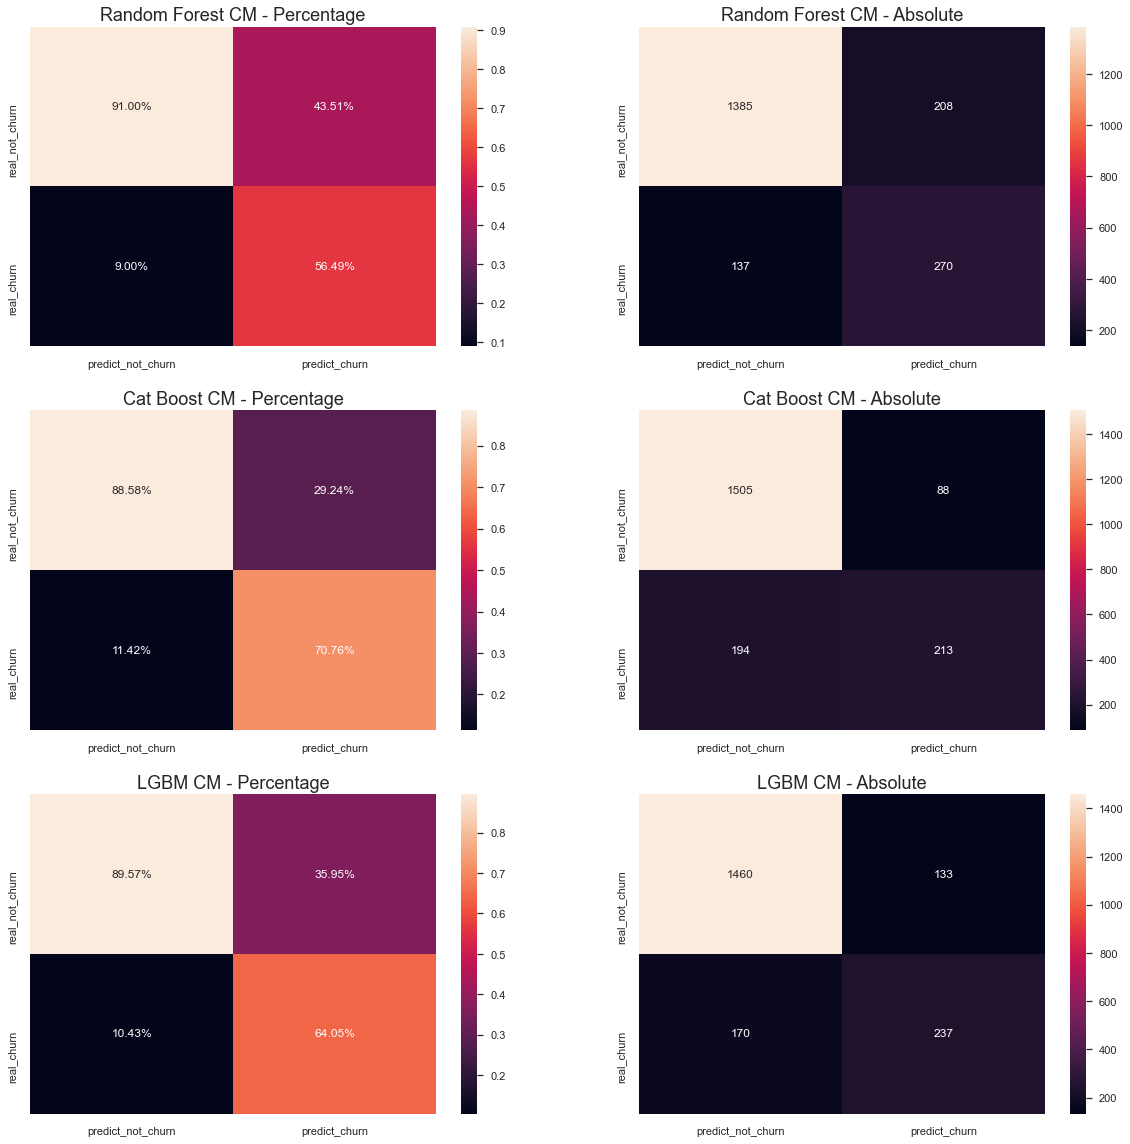

In [204]:
_, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 20))

# Random Forest
sns.heatmap(cm_RF/np.sum(cm_RF), annot=True, fmt='.2%', ax=ax1).set_title('Random Forest CM - Percentage', fontsize = 18)
sns.heatmap(cm_RF, annot=True, fmt='d', ax=ax2).set_title('Random Forest CM - Absolute', fontsize = 18);

# Cat Boost
sns.heatmap(cm_CB/np.sum(cm_CB), annot=True, fmt='.2%', ax=ax3).set_title('Cat Boost CM - Percentage', fontsize = 18)
sns.heatmap(cm_CB, annot=True, fmt='d', ax=ax4).set_title('Cat Boost CM - Absolute', fontsize = 18);

# LGBM
sns.heatmap(cm_LGBM/np.sum(cm_LGBM), annot=True, fmt='.2%', ax=ax5).set_title('LGBM CM - Percentage', fontsize = 18)
sns.heatmap(cm_LGBM, annot=True, fmt='d', ax=ax6).set_title('LGBM CM - Absolute', fontsize = 18);

## Business Performance

- Cat Boost Classifier has a better performance, predicting correctly **70,76%** of **TRUE POSITIVE CHURN** cases and **88,58%** of **TRUE NEGATIVE CHURN** cases.

- This is not a simple binary classification problem, but rather a probability sorting problem, where we need to identify which customers are most likely to churn.

- Our goal hier is to predict the probability of a client get into churn (TRUE POSITIVE CHURN) and try to avoid it.

In [248]:
X_test_normal['Exited'] = y_test

In [249]:
X_test_normal['ChurnProbability'] = [(p * 100) for i, p in y_proba_CBC_FT.tolist()]

In [259]:
X_test_normal['Exited_pred'] = y_hat_CBC_FT

In [264]:
X_test_normal['Exited'].value_counts(normalize=True)

0    0.7965
1    0.2035
Name: Churn, dtype: float64

In [262]:
X_test_normal['Exited_pred'].value_counts(normalize=True)

0    0.8495
1    0.1505
Name: Exited_pred, dtype: float64

In [280]:
# Probabilities between 65% and 95% of probabilit to churn (test dataset)
display(len(X_test_normal[(X_test_normal['ChurnProbability'] <= 95) & (X_test_normal['ChurnProbability'] >= 65)]))

# Probabilities between 85% and 95% of probabilit to churn (test dataset)
display(len(X_test_normal[(X_test_normal['ChurnProbability'] <= 95) & (X_test_normal['ChurnProbability'] > 85)]))

# Probabilities between 75% and 85% of probabilit to churn (test dataset)
display(len(X_test_normal[(X_test_normal['ChurnProbability'] <= 85) & (X_test_normal['ChurnProbability'] > 75)]))

# Probabilities between 65% and 75% of probabilit to churn (test dataset)
display(len(X_test_normal[(X_test_normal['ChurnProbability'] <= 75) & (X_test_normal['ChurnProbability'] >= 65)]))

157

67

40

50

In [279]:
# Probabilities between 85% and 95% of probabilit to churn - U$ 100 gift card
print('U$', len(X_test_normal[(X_test_normal['ChurnProbability'] <= 95) & (X_test_normal['ChurnProbability'] > 85)]) * 100)

# Probabilities between 75% and 85% of probabilit to churn - U$ 50 gift card
print('U$', len(X_test_normal[(X_test_normal['ChurnProbability'] <= 85) & (X_test_normal['ChurnProbability'] > 75)]) * 50)

# Probabilities between 65% and 75% of probabilit to churn - U$ 25 gift card
print('U$', len(X_test_normal[(X_test_normal['ChurnProbability'] <= 75) & (X_test_normal['ChurnProbability'] >= 65)]) * 25)

U$ 6700
U$ 2000
U$ 1250


## Entire Dataset Test

In [375]:
X_prep = df4

GET DUMMIES
# Geografphy
X_prep = pd.get_dummies(X_prep, prefix = 'Geo', columns = ['Geography'])

# Gender
X_prep = pd.get_dummies(X_prep, prefix='Gender', columns=['Gender'])

# Has credit Card
X_prep = pd.get_dummies(X_prep, prefix='HasCrCard', columns=['HasCrCard'])

# is active member
X_prep = pd.get_dummies(X_prep, prefix='IsActiveMember', columns=['IsActiveMember'])

# ORINAL ENCODER
encoder = OrdinalEncoder()
# BalanceCut
X_prep['BalanceCut'] = encoder.fit_transform(np.array(X_prep['BalanceCut']).reshape(-1,1))

# CatEstSalary
X_prep['CatEstSalary'] = encoder.fit_transform(np.array(X_prep['CatEstSalary']).reshape(-1,1))

# Num of products
X_prep['NumOfProducts'] = encoder.fit_transform(np.array(X_prep['NumOfProducts']).reshape(-1,1))

# STANDARD SCALER
# Credit Score - distribution close to a normal.
ss = StandardScaler()
X_prep['CreditScore'] = ss.fit_transform(X_prep[['CreditScore']].values)

# MIN MAX SCALER
mms = MinMaxScaler()
# Age
X_prep['Age'] = mms.fit_transform(X_prep[['Age']].values)

# Tenure
X_prep['Tenure'] = mms.fit_transform(X_prep[['Tenure']].values)

# Balance
X_prep['Balance'] = mms.fit_transform(X_prep[['Balance']].values)

# Estimated Salary
X_prep['EstimatedSalary'] = mms.fit_transform(X_prep[['EstimatedSalary']].values)

# balance Per Age
X_prep['BalancePerAge'] = mms.fit_transform(X_prep[['BalancePerAge']].values)

In [379]:
# Drop clients that we already know that are exited and we cant bring this customers back.
#X_prep = X_prep[X_prep['Exited'] != 1]
#X = df4[df4['Exited'] != 1]

# Drop "Exited" column.
#X_prep = X_prep.drop('Exited', axis = 1)
X = df4

In [380]:
X_prep.shape

(10000, 19)

In [381]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceCut,CatEstSalary,BalancePerAge
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,"(-1.0, 1000.0]","(100193.915, 149388.248]",0.00
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,"(50000.0, 100000.0]","(100193.915, 149388.248]",2044.09
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,"(150000.0, 200000.0]","(100193.915, 149388.248]",3801.45
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,"(-1.0, 1000.0]","(51002.11, 100193.915]",0.00
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,"(100000.0, 150000.0]","(51002.11, 100193.915]",2918.86


In [382]:
y_proba_CBC_FT = CBC.predict_proba(X_prep)
y_hat_CBC_FT = CBC.predict(X_prep)

In [383]:
X['ChurnProbability'] = [round((p * 100), 2) for i, p in y_proba_CBC_FT.tolist()]

In [385]:
print(f'Churn probability bigger than 99%: {len(X[X["ChurnProbability"] >= 99])} customers.')
print(f'Churn probability between 95% and 99%: {len(X[(X["ChurnProbability"] >= 95) & (X["ChurnProbability"] < 99)])} customers.')
print(f'Churn probability between 85% and 95%: {len(X[(X["ChurnProbability"] >= 85) & (X["ChurnProbability"] < 95)])} customers.')
print(f'Churn probability bigger than 50%: {len(X[X["ChurnProbability"] > 50])} customers.')

Churn probability bigger than 99%: 104 customers.
Churn probability between 95% and 99%: 216 customers.
Churn probability between 85% and 95%: 362 customers.
Churn probability bigger than 50%: 1560 customers.


## 1st Scenario 

    - Clients with churn probabilities above than 95% has no chance od return, they are already decided and don't matter what we do, they will go out.

    - Give $100 for the first 100 clients between 85% and 95% of churn probability with the bigger estimated salary, totalizing $10000 of investiments.

In [398]:
X['AVGSalary'] = X['EstimatedSalary'].apply(lambda x: 'bigger' if x > X['EstimatedSalary'].mean() else 'lower')

In [400]:
# Sort by estimated salary
X[(X["ChurnProbability"] >= 85) & (X["ChurnProbability"] < 95)].sort_values(by='EstimatedSalary', ascending=False).head(100)['AVGSalary'].value_counts()

bigger    100
Name: AVGSalary, dtype: int64

**All of the customers between 85% and 95% of churn probability sorted by "EstimatedSalary" have an "EstimatedSalary" bigger than the average "EstimatedSalary", therefore, they monetize annualy 20% of their "EstimatedSalary".**

    - Strategy: Give $100 for the 100 customers with the bigger estimated salary with probabilities of churn between 85% and 95%.
    - Assuming that we have a "return of churn rate" of 100%if we offer a voucher of $100, all of them will return 20% as revenue.

In [404]:
estimated_revenue = round(X[(X["ChurnProbability"] >= 85) & (X["ChurnProbability"] < 95)].sort_values(by='EstimatedSalary', ascending=False).head(100)['EstimatedSalary'].sum() * 0.2, 2)
print(f'Estimated revenue: ${estimated_revenue - 10000}')

Estimated revenue: $3460129.39


## 2nd Scenario

    - Give $100 for the first 50 customers sorted by greater estimated salary.

    - Give $75 for the next 50 customers.

    - Give $50 for the last 25 customers.
    
Total investiment: $10000